In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.sqr_gaussian_inference import * 
from src.gaussian_inference import *
from src.ODE_filters import *
from src.helpers import future_prediction

In [2]:
from tueplots import axes
plt.rcParams.update(axes.lines())
plt.rcParams.update({"figure.dpi": 300})

In [3]:
#from tueplots import figsizes
#figsize_config = figsizes.neurips2021(nrows=4, ncols=1)
##figsize_config['figure.figsize'][1] = 0.5
#plt.rcParams.update(figsize_config)

In [4]:
#ODE - IVP:
vf = lambda x: x*(1-x)
y0 = 0.01

#exact solution:
x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))
x_prime_exact = lambda t: (1 / 0.01 - 1) * np.exp(-t) / (1 + (1 / 0.01 - 1) * np.exp(-t))**2
x_prime_prime_exact = lambda t: x_exact(t)*(1-x_exact(t))*(1-2*x_exact(t))
exact_sols = [x_exact, x_prime_exact, x_prime_prime_exact]

#Prior
A = lambda h: np.array([[1, h, h**2/2], [0, 1, h], [0, 0, 1]])
sigma = 1.0
Q = lambda h: sigma**2 * np.array([[h**5/20, h**4/8, h**3/6], [h**4/8, h**3/3, h**2/2], [h**3/6, h**2/2, h]])
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])
mu_0 = X_0
Sigma_0 = np.eye(3)*0.

#Discretization
t0, t1 = 0.0, 10.0
N = 20
ts = np.linspace(t0, t1, num=N+1, endpoint=True)
t = np.linspace(t0,t1, 100)
h = (t1 - t0) / N


#Consequences of constant step size
A_h = A(h)
Q_h = Q(h)
b_h = np.zeros(3)
R_h = np.array([[0.0]])

#Measurement operator
g = lambda X: np.array([X[1] - vf(X[0])])
jacobian_g = lambda X: np.array([[2*X[0] - 1, 1, 0]])

#Data
z_sequence = np.zeros(N).reshape(-1,1)

In [5]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

In [6]:
def plot_graph(ts, m, P, t, x_exact, x_lim=None, y_lim=None):
    plt.figure(figsize=(10,5))
    plt.plot(t, x_exact(t), linestyle='--', color="black")
    plt.plot(ts, m, color='red')
    plt.scatter(ts, m, color='red')
    P_f_safe = np.maximum(P, 0)
    margin = np.sqrt(P_f_safe)
    plt.fill_between(ts,m-margin, m+margin, alpha=0.2, color='red')
    if x_lim != None:
        plt.xlim(x_lim)
    if y_lim != None:
        plt.ylim(y_lim)
    plt.show()

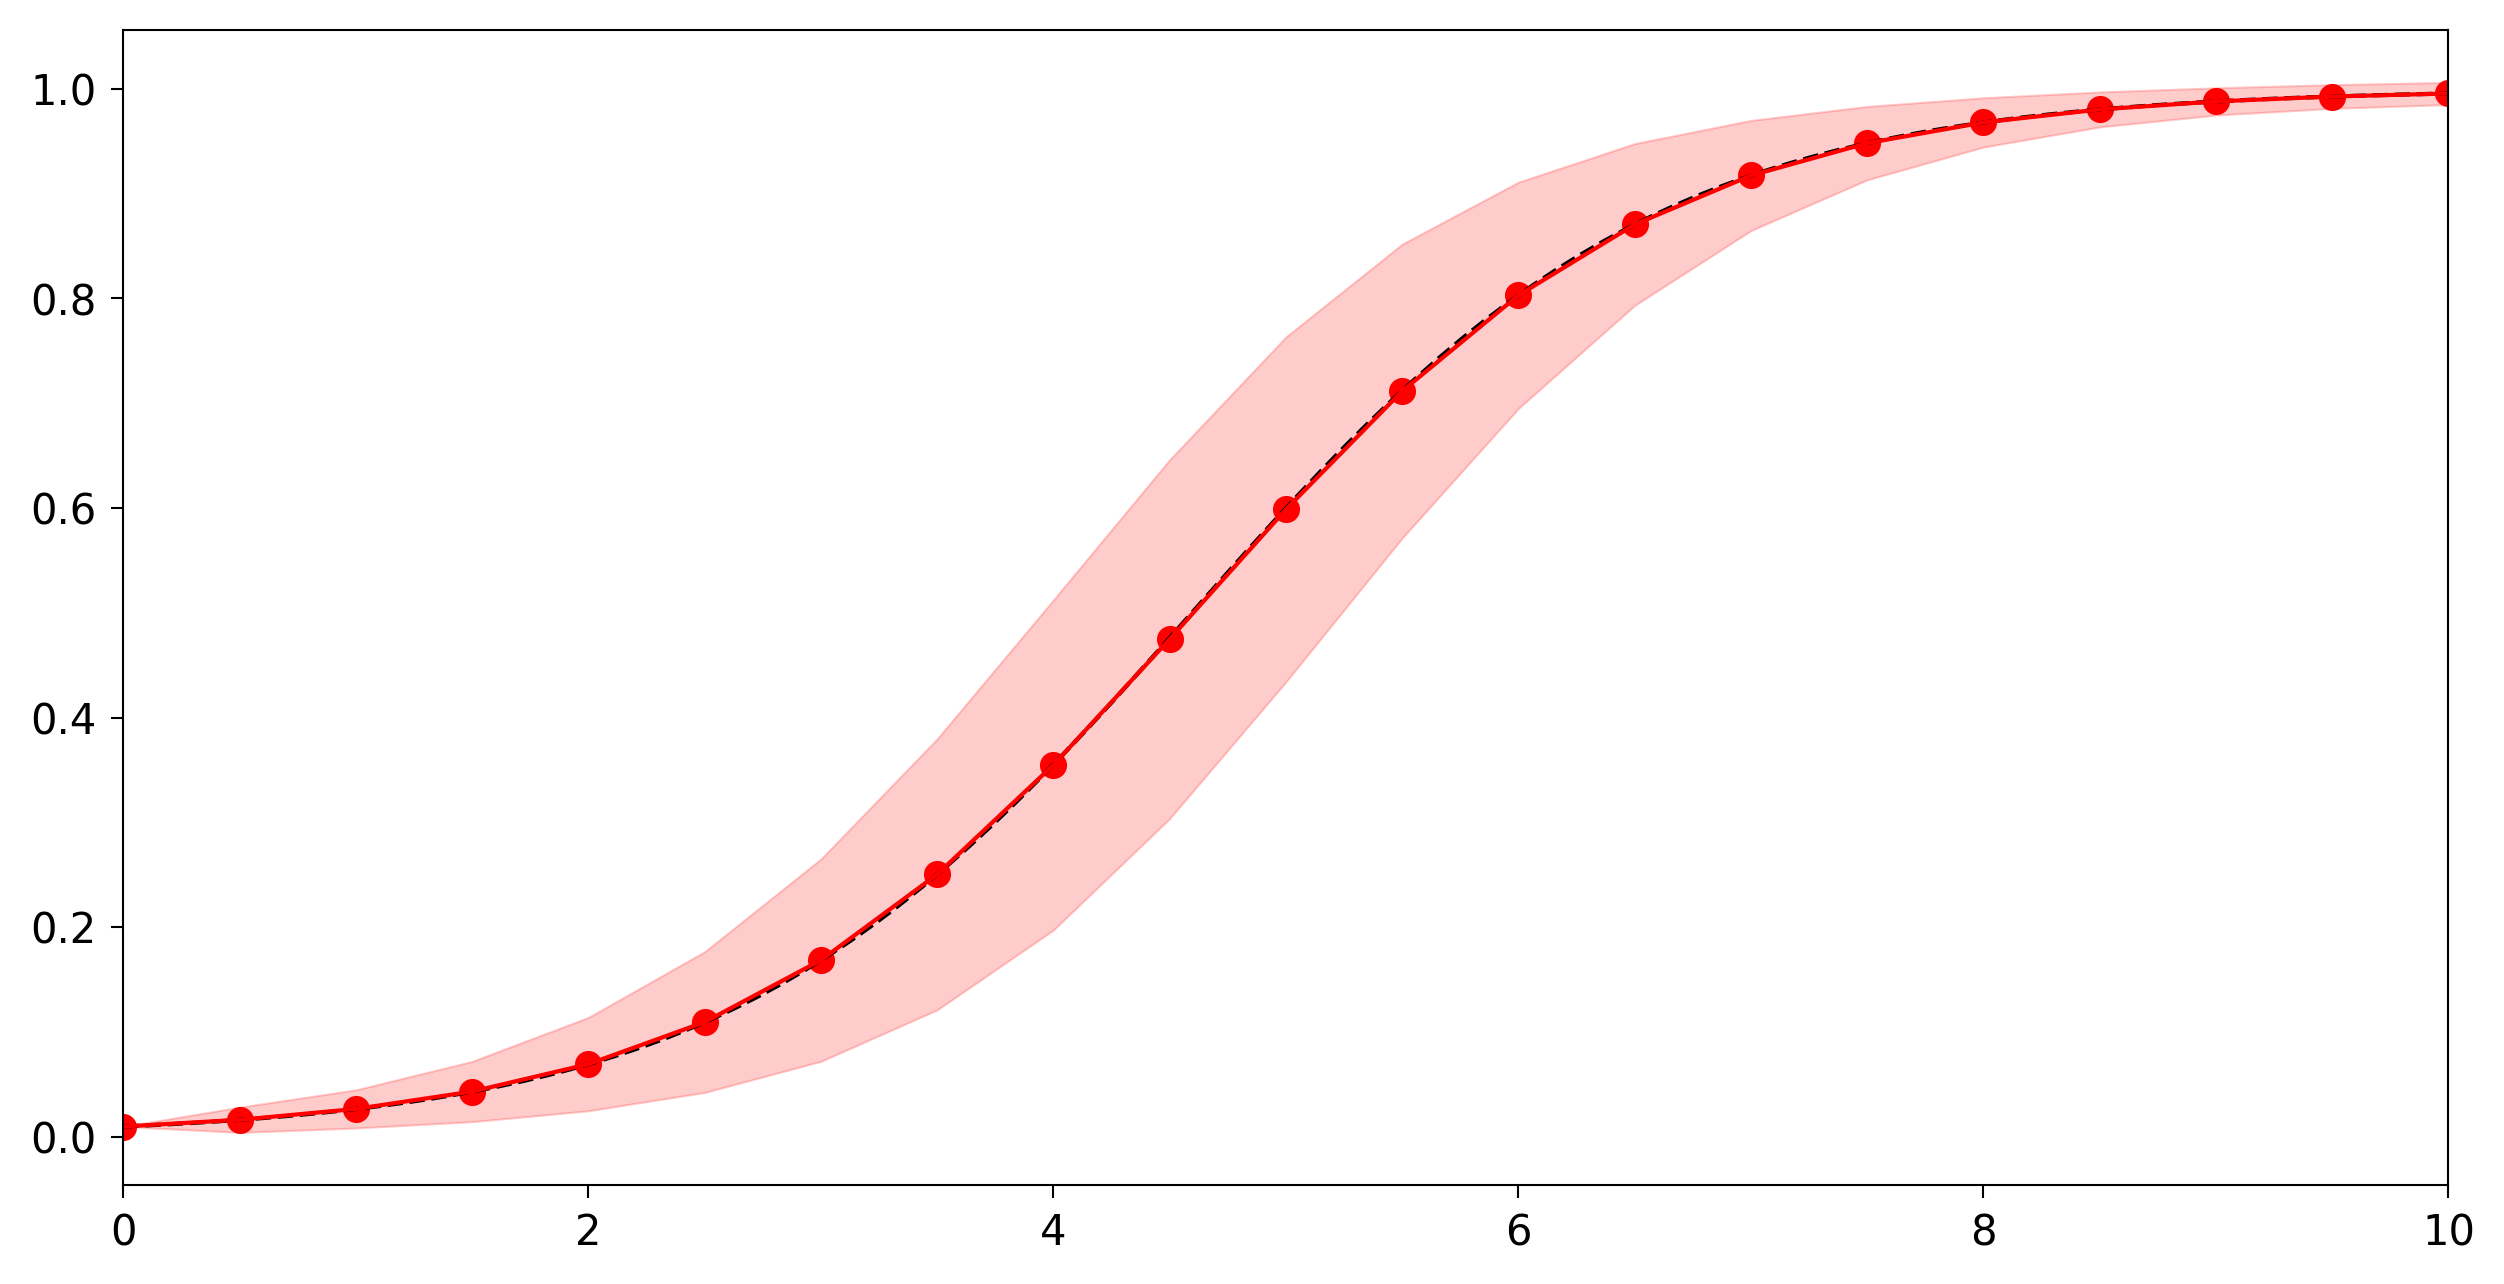

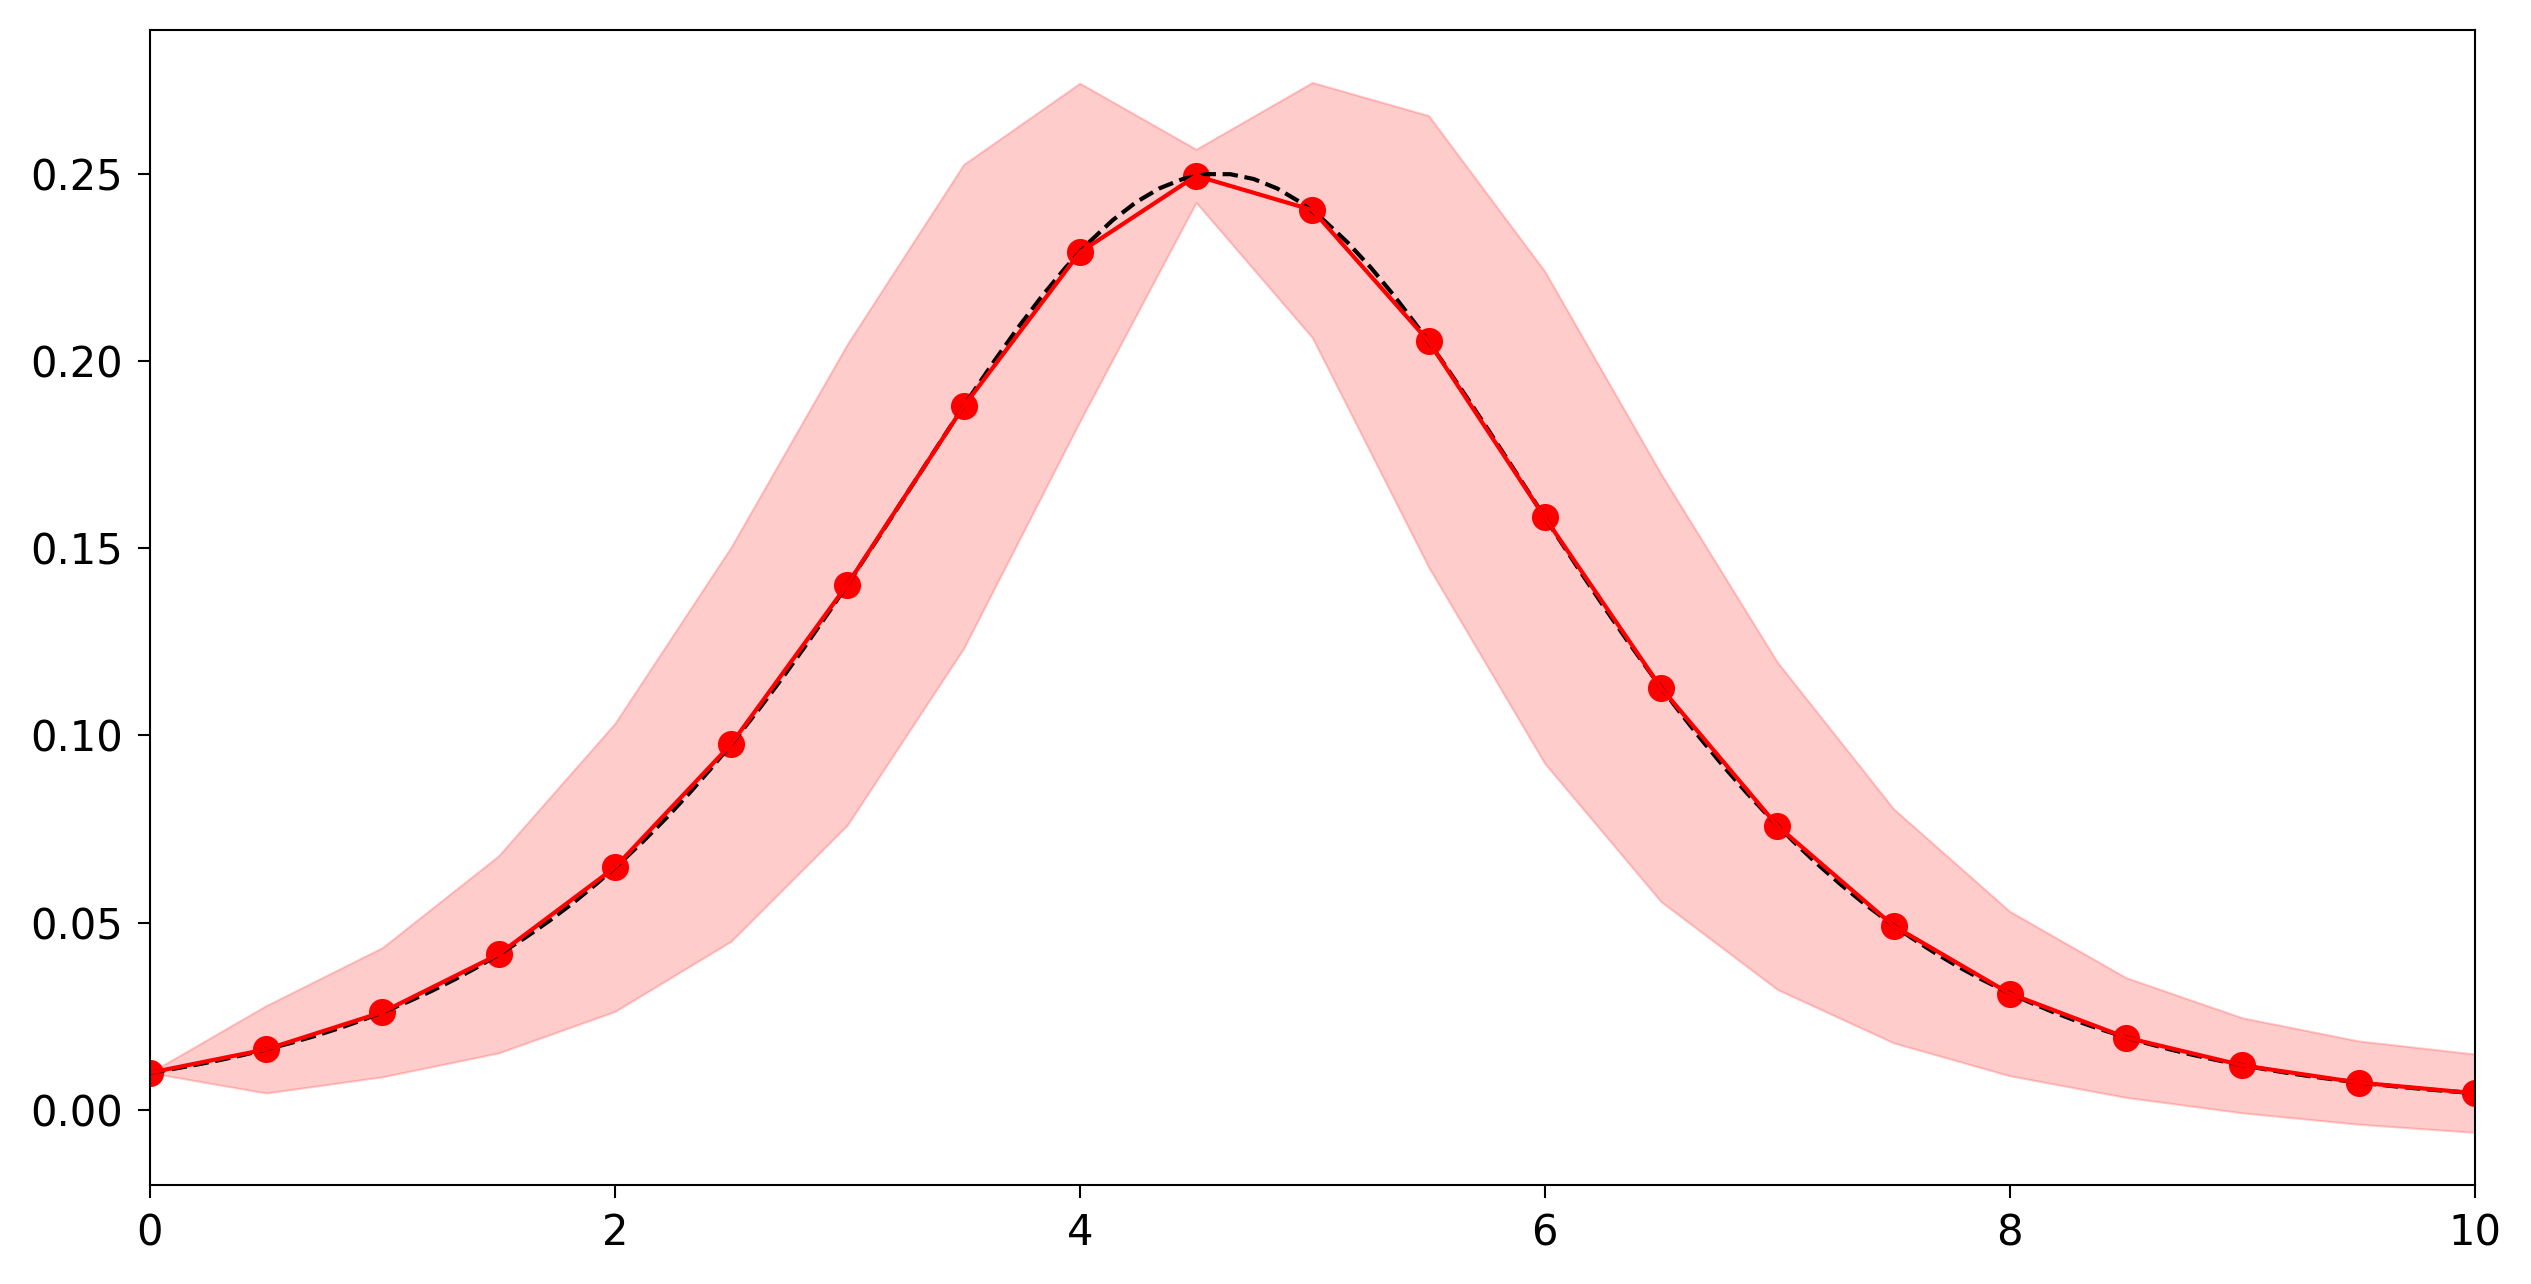

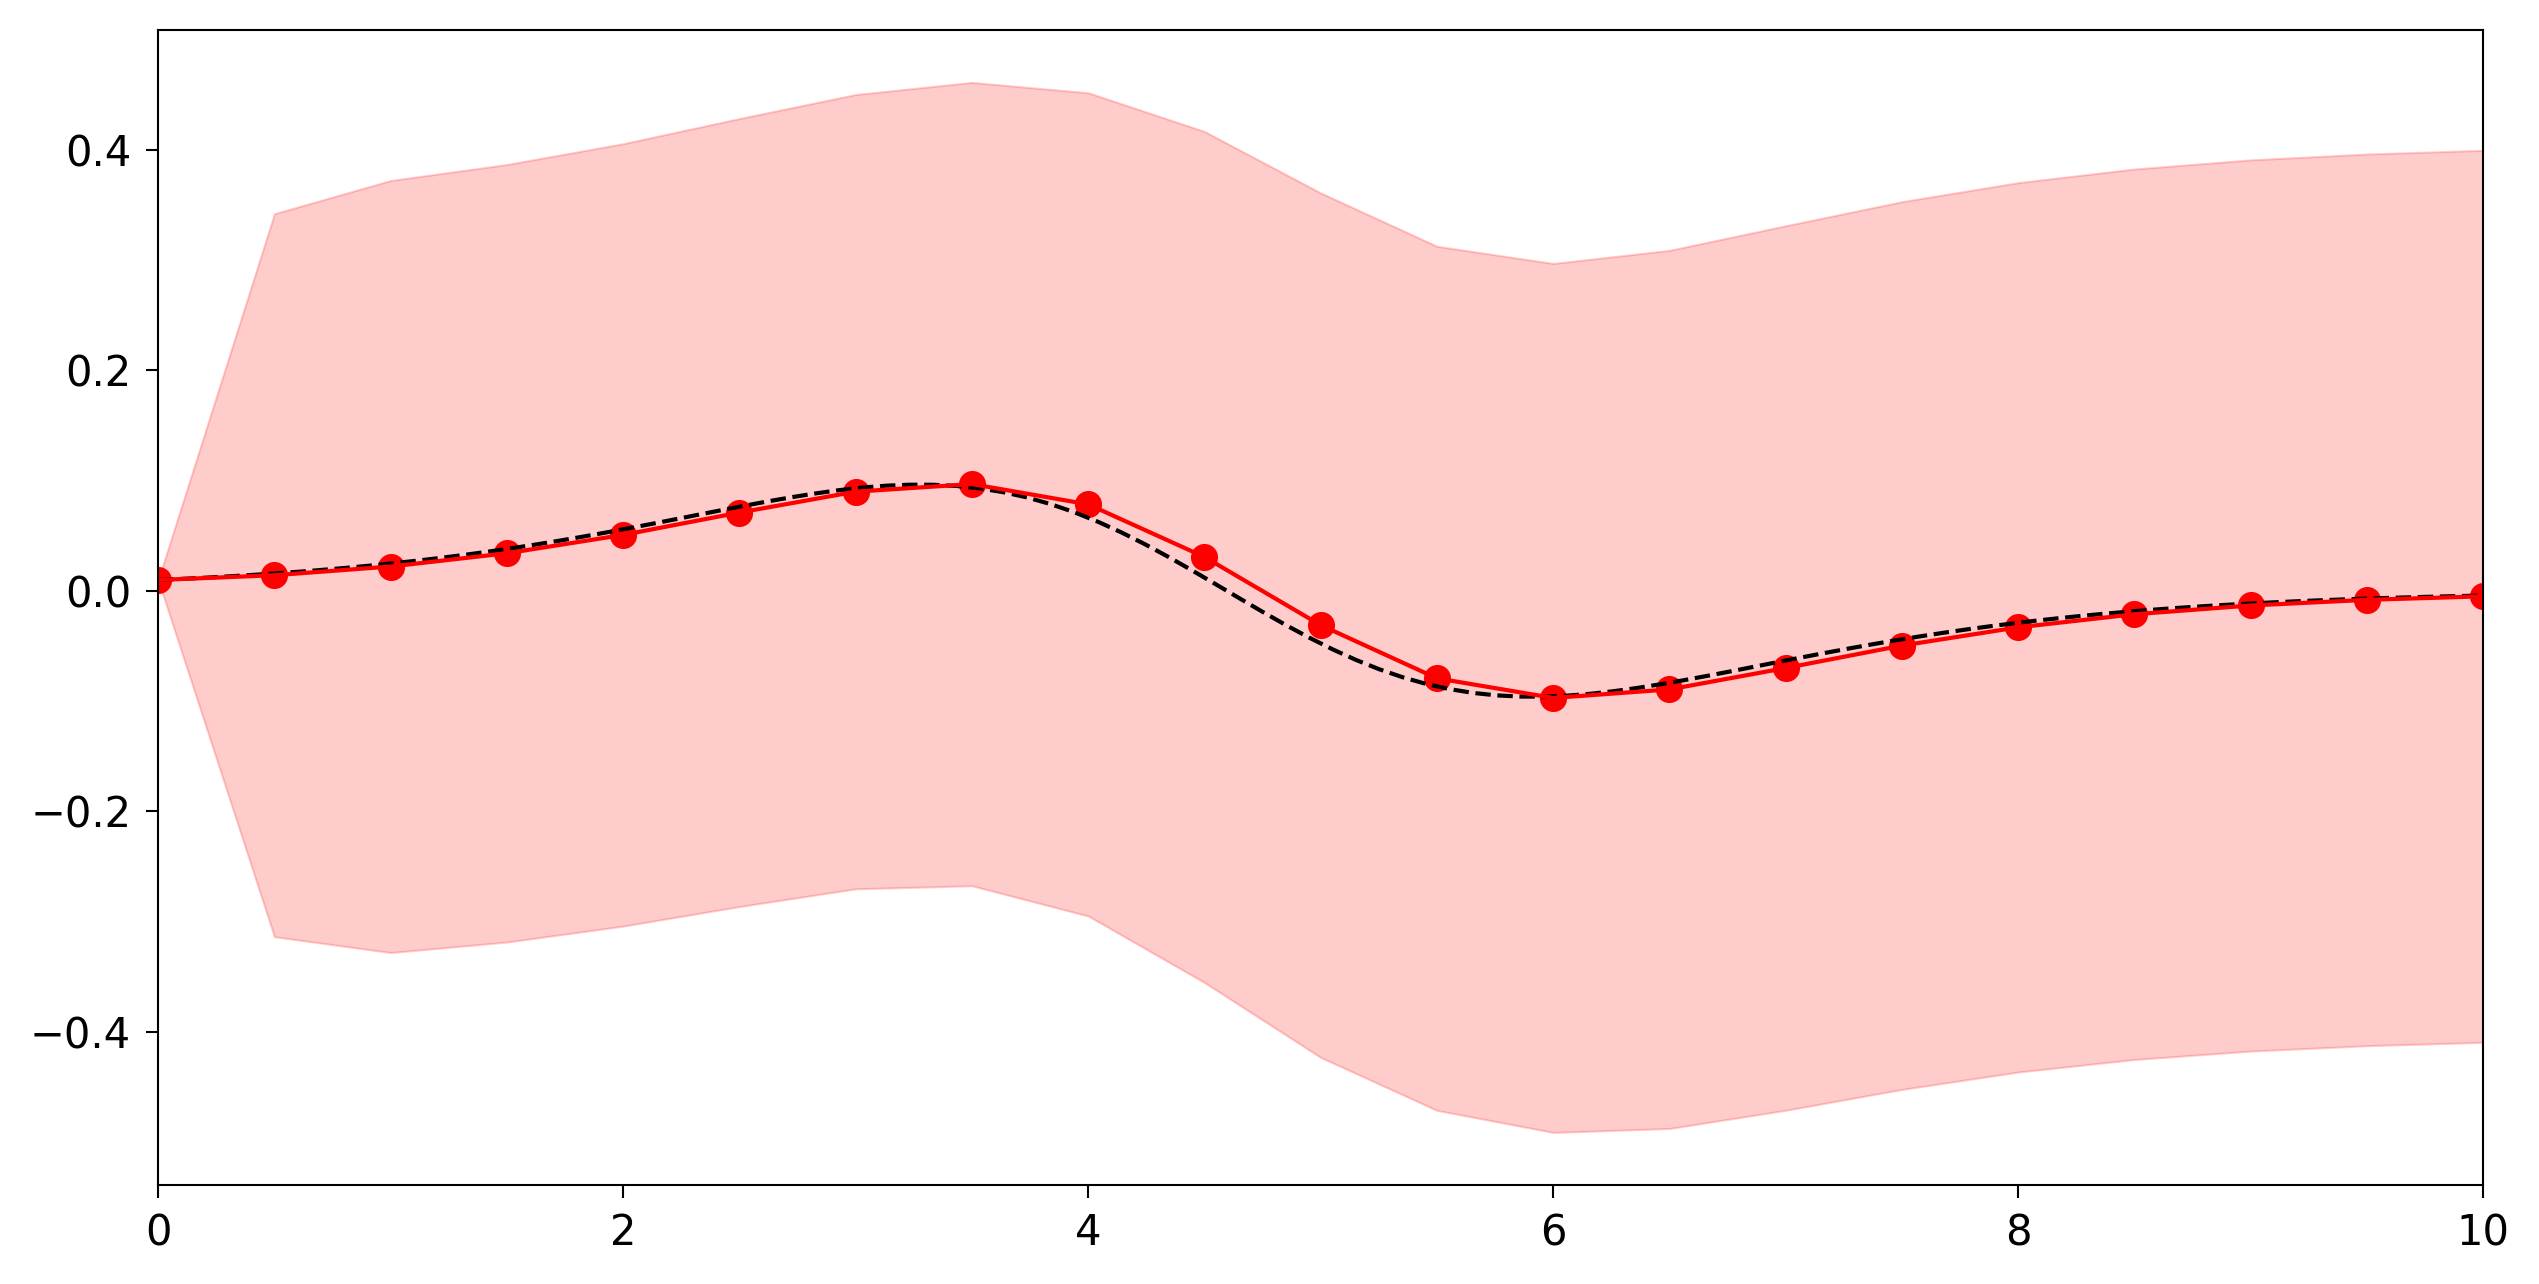

In [7]:
for k in range(3):
    plot_graph(ts, m_sequence[:,k], P_sequence[:,k,k], t, exact_sols[k],x_lim=[0,10])

### Compare stable sqr computed version with "unstable" version

as you will see here in the following, for the logistic ODE the results are identical, but they might me different for different e.g. stiff ODEs. 

In [8]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

m_sequence2, P_sequence2, m_predictions2, P_predictions2 = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

In [9]:
def plot_graph2(ts, m, P, m2, P2, t, x_exact):
    plt.figure(figsize=(10,5))
    plt.plot(t, x_exact(t), linestyle='--', color="black")
    plt.plot(ts, m, color='red')
    plt.scatter(ts, m, color='red')
    P_f_safe = np.maximum(P, 0)
    margin = np.sqrt(P_f_safe)
    plt.fill_between(ts,m-margin, m+margin, alpha=0.2, color='red')

    plt.scatter(ts, m2, color='blue')
    plt.plot(ts, m2, color='blue')
    P_f_safe2 = np.maximum(P2, 0)
    margin2 = np.sqrt(P_f_safe2)
    plt.fill_between(ts,m2-margin2, m2+margin2, alpha=0.2, color='blue')
    plt.show()

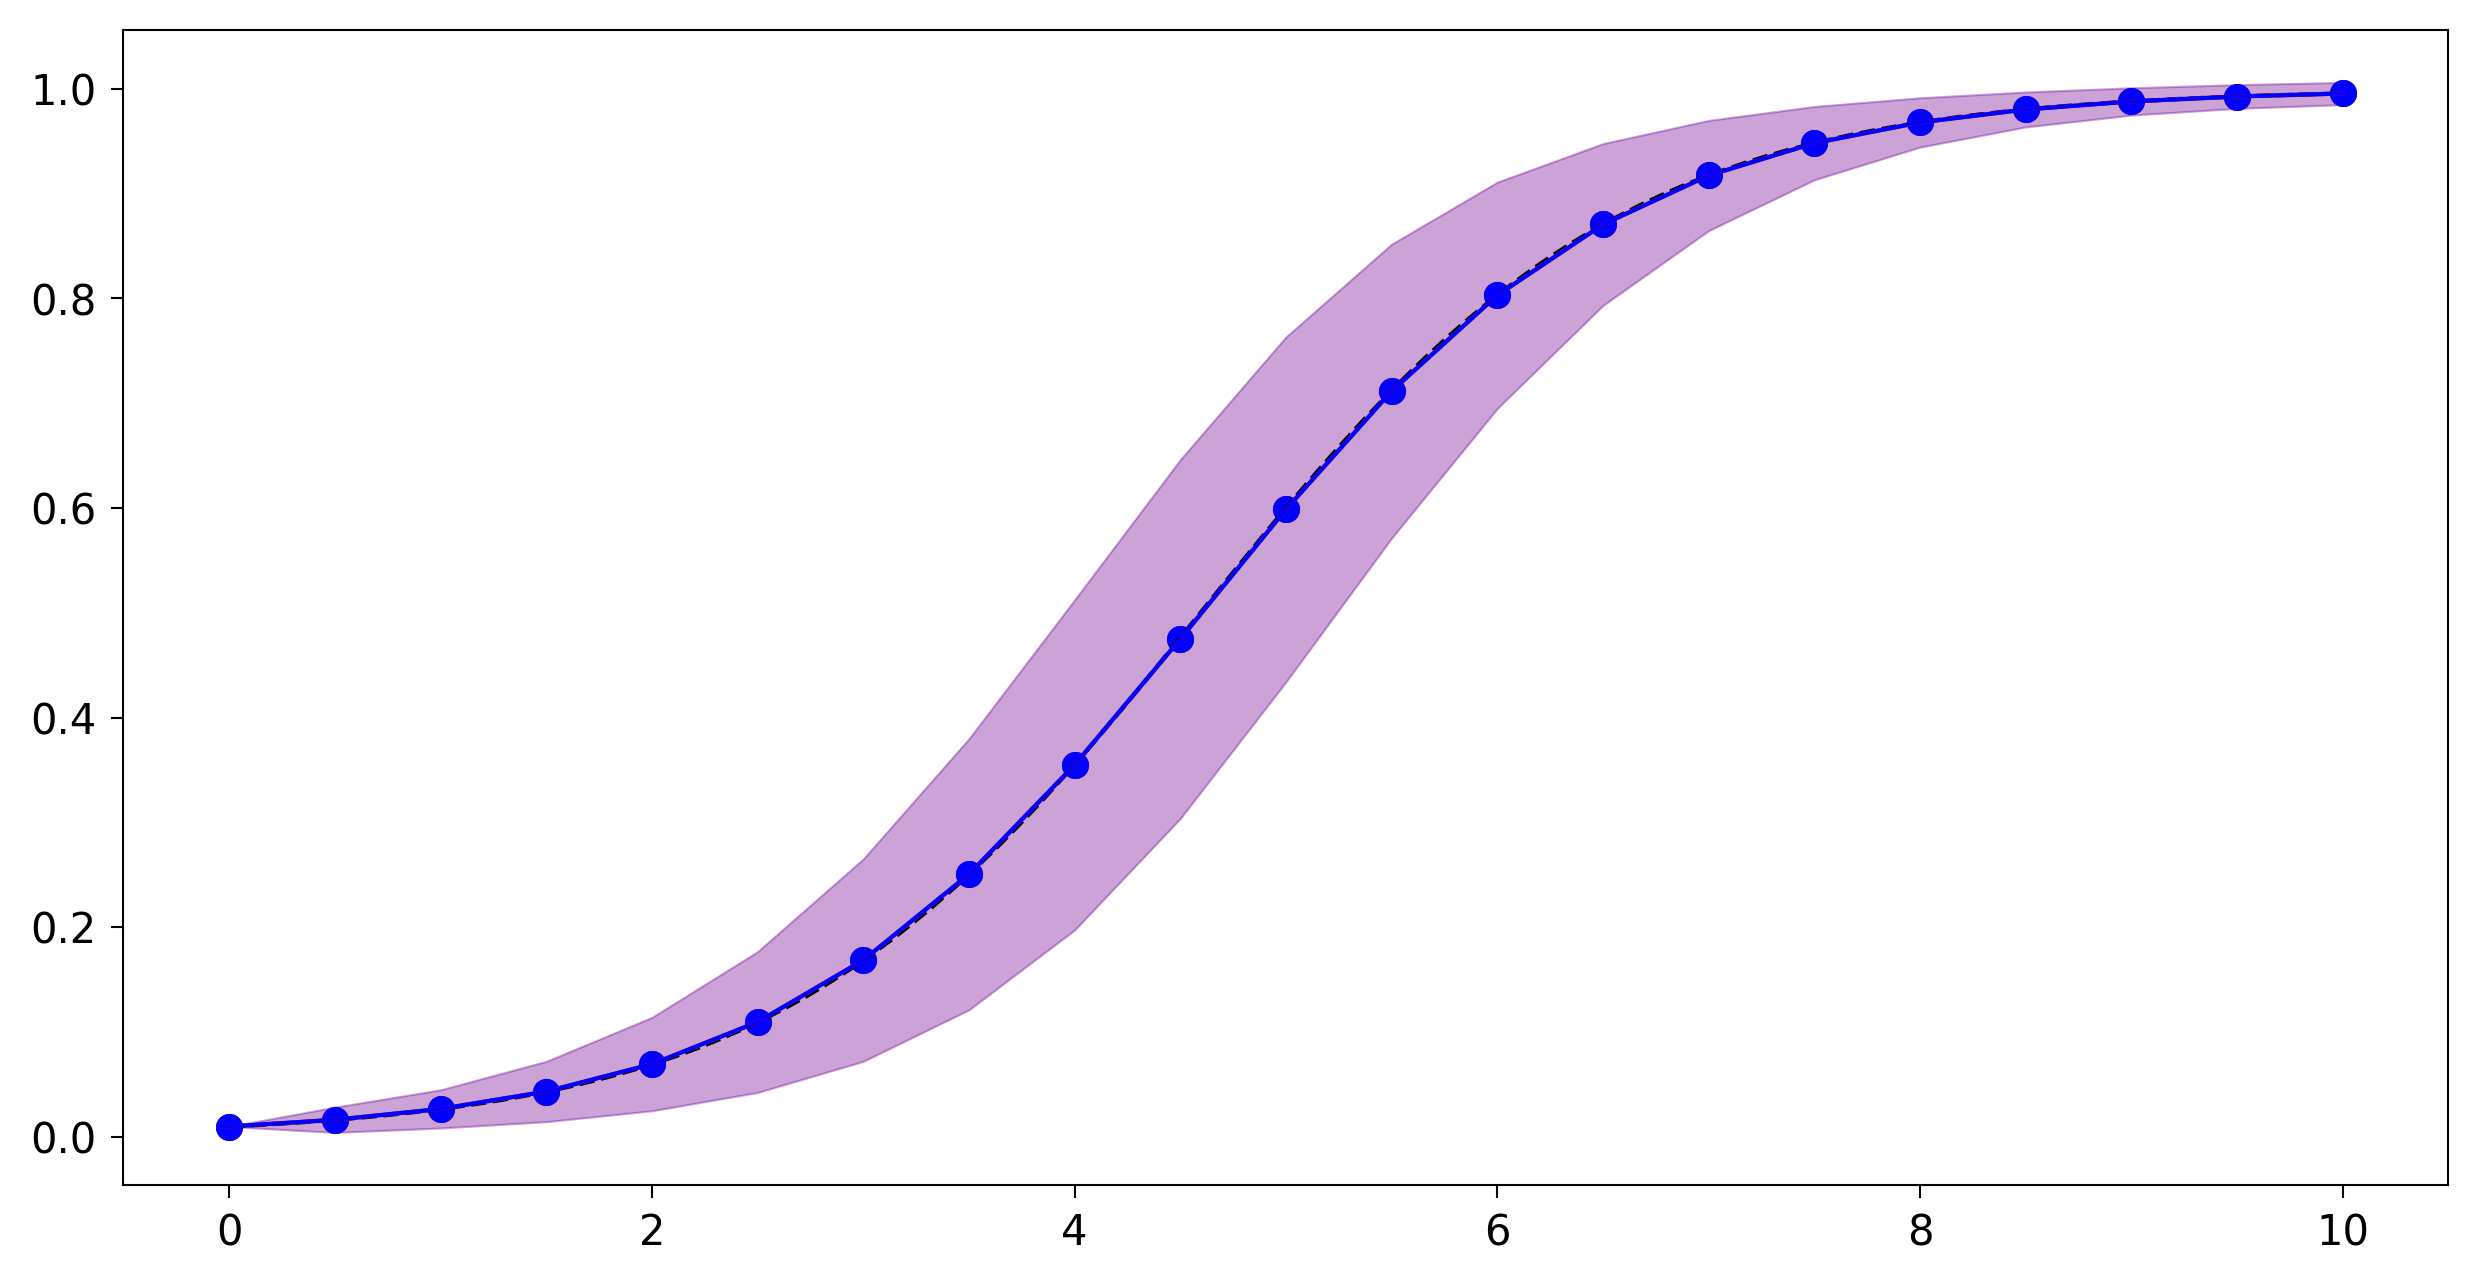

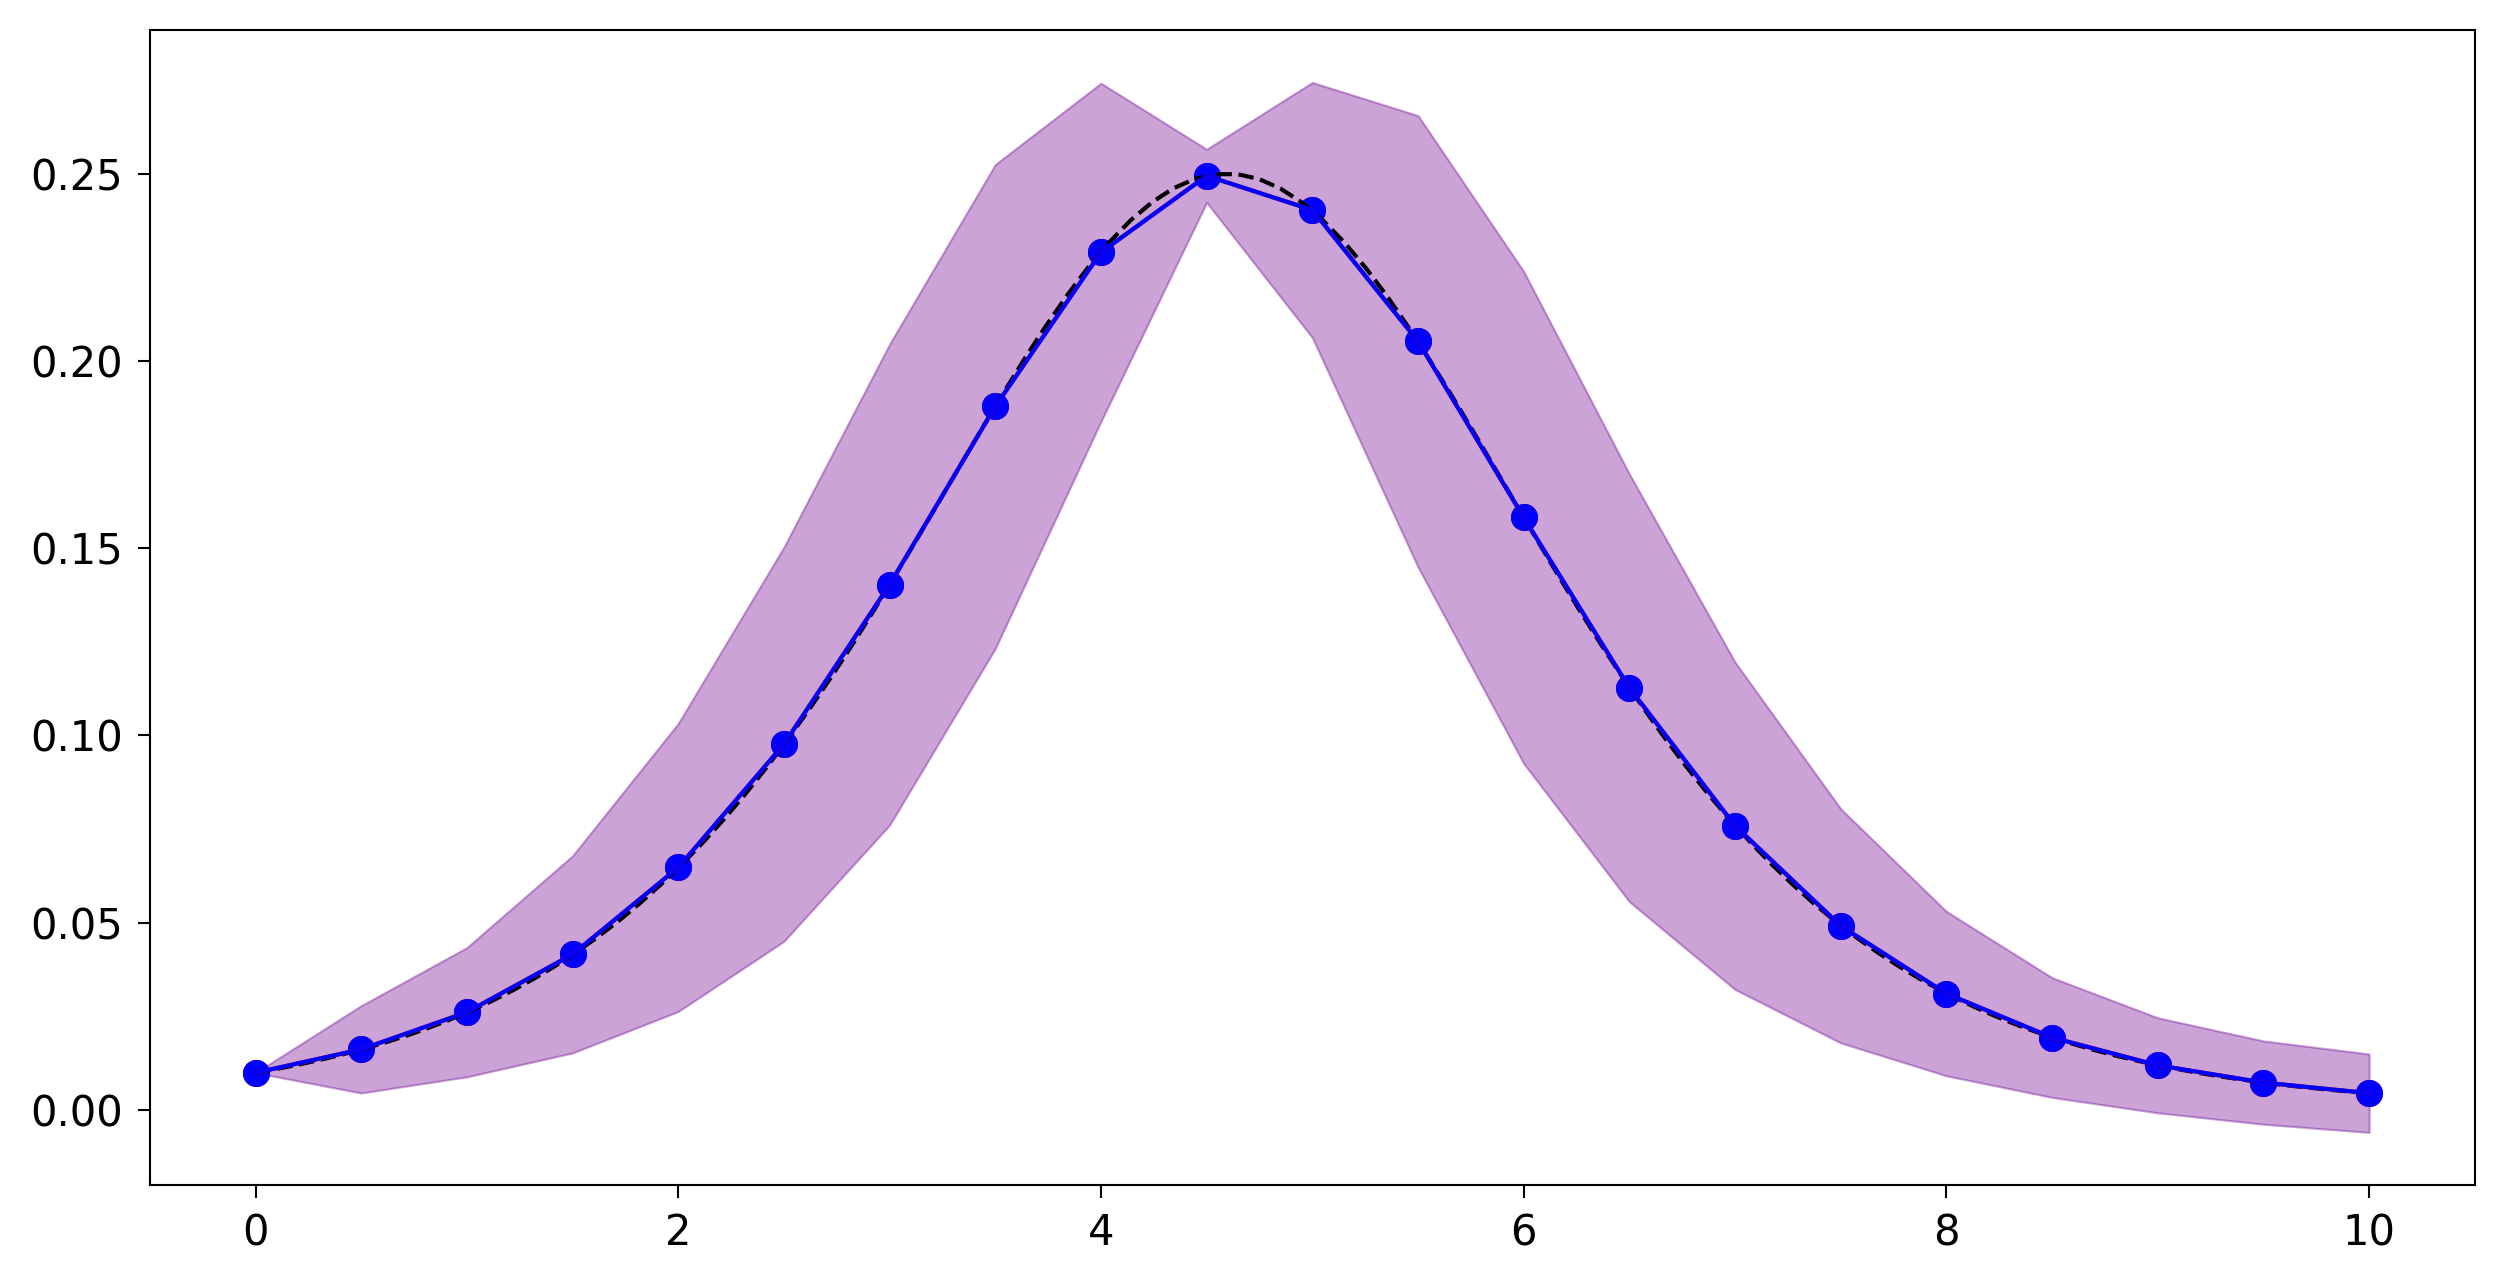

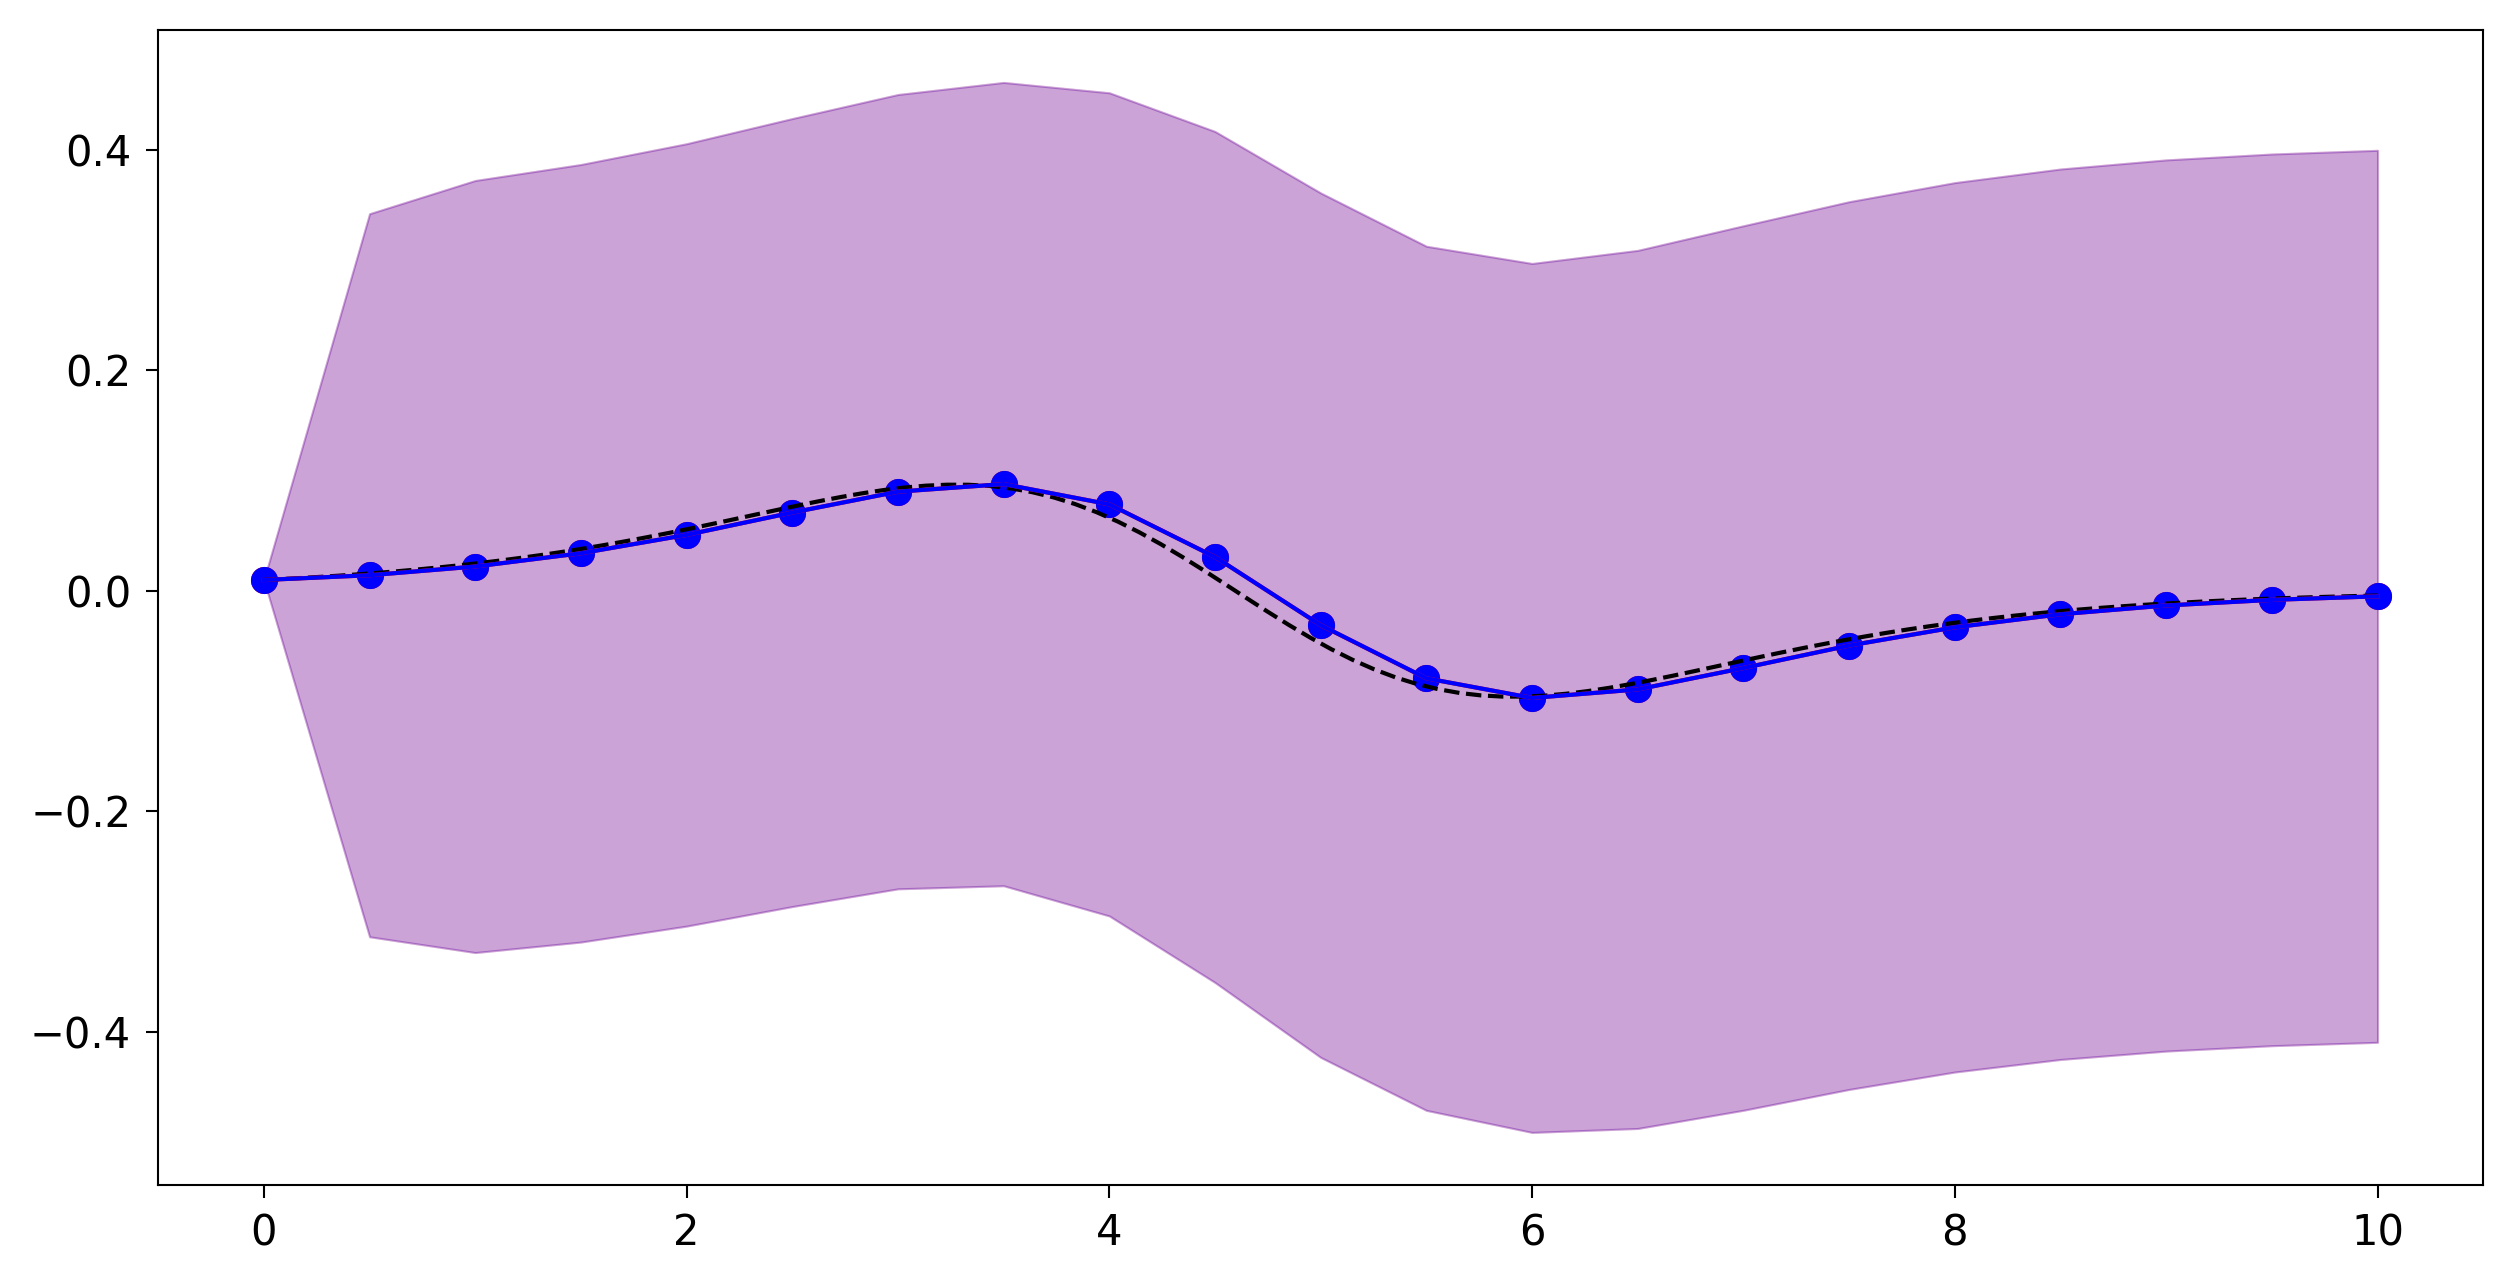

In [10]:
for k in range(3):
    plot_graph2(ts, m_sequence[:,k], P_sequence[:,k,k],m_sequence2[:,k], P_sequence2[:,k,k], t, exact_sols[k])

### Smooth the filtered results


In [11]:
m_smoothed, P_smoothed = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)

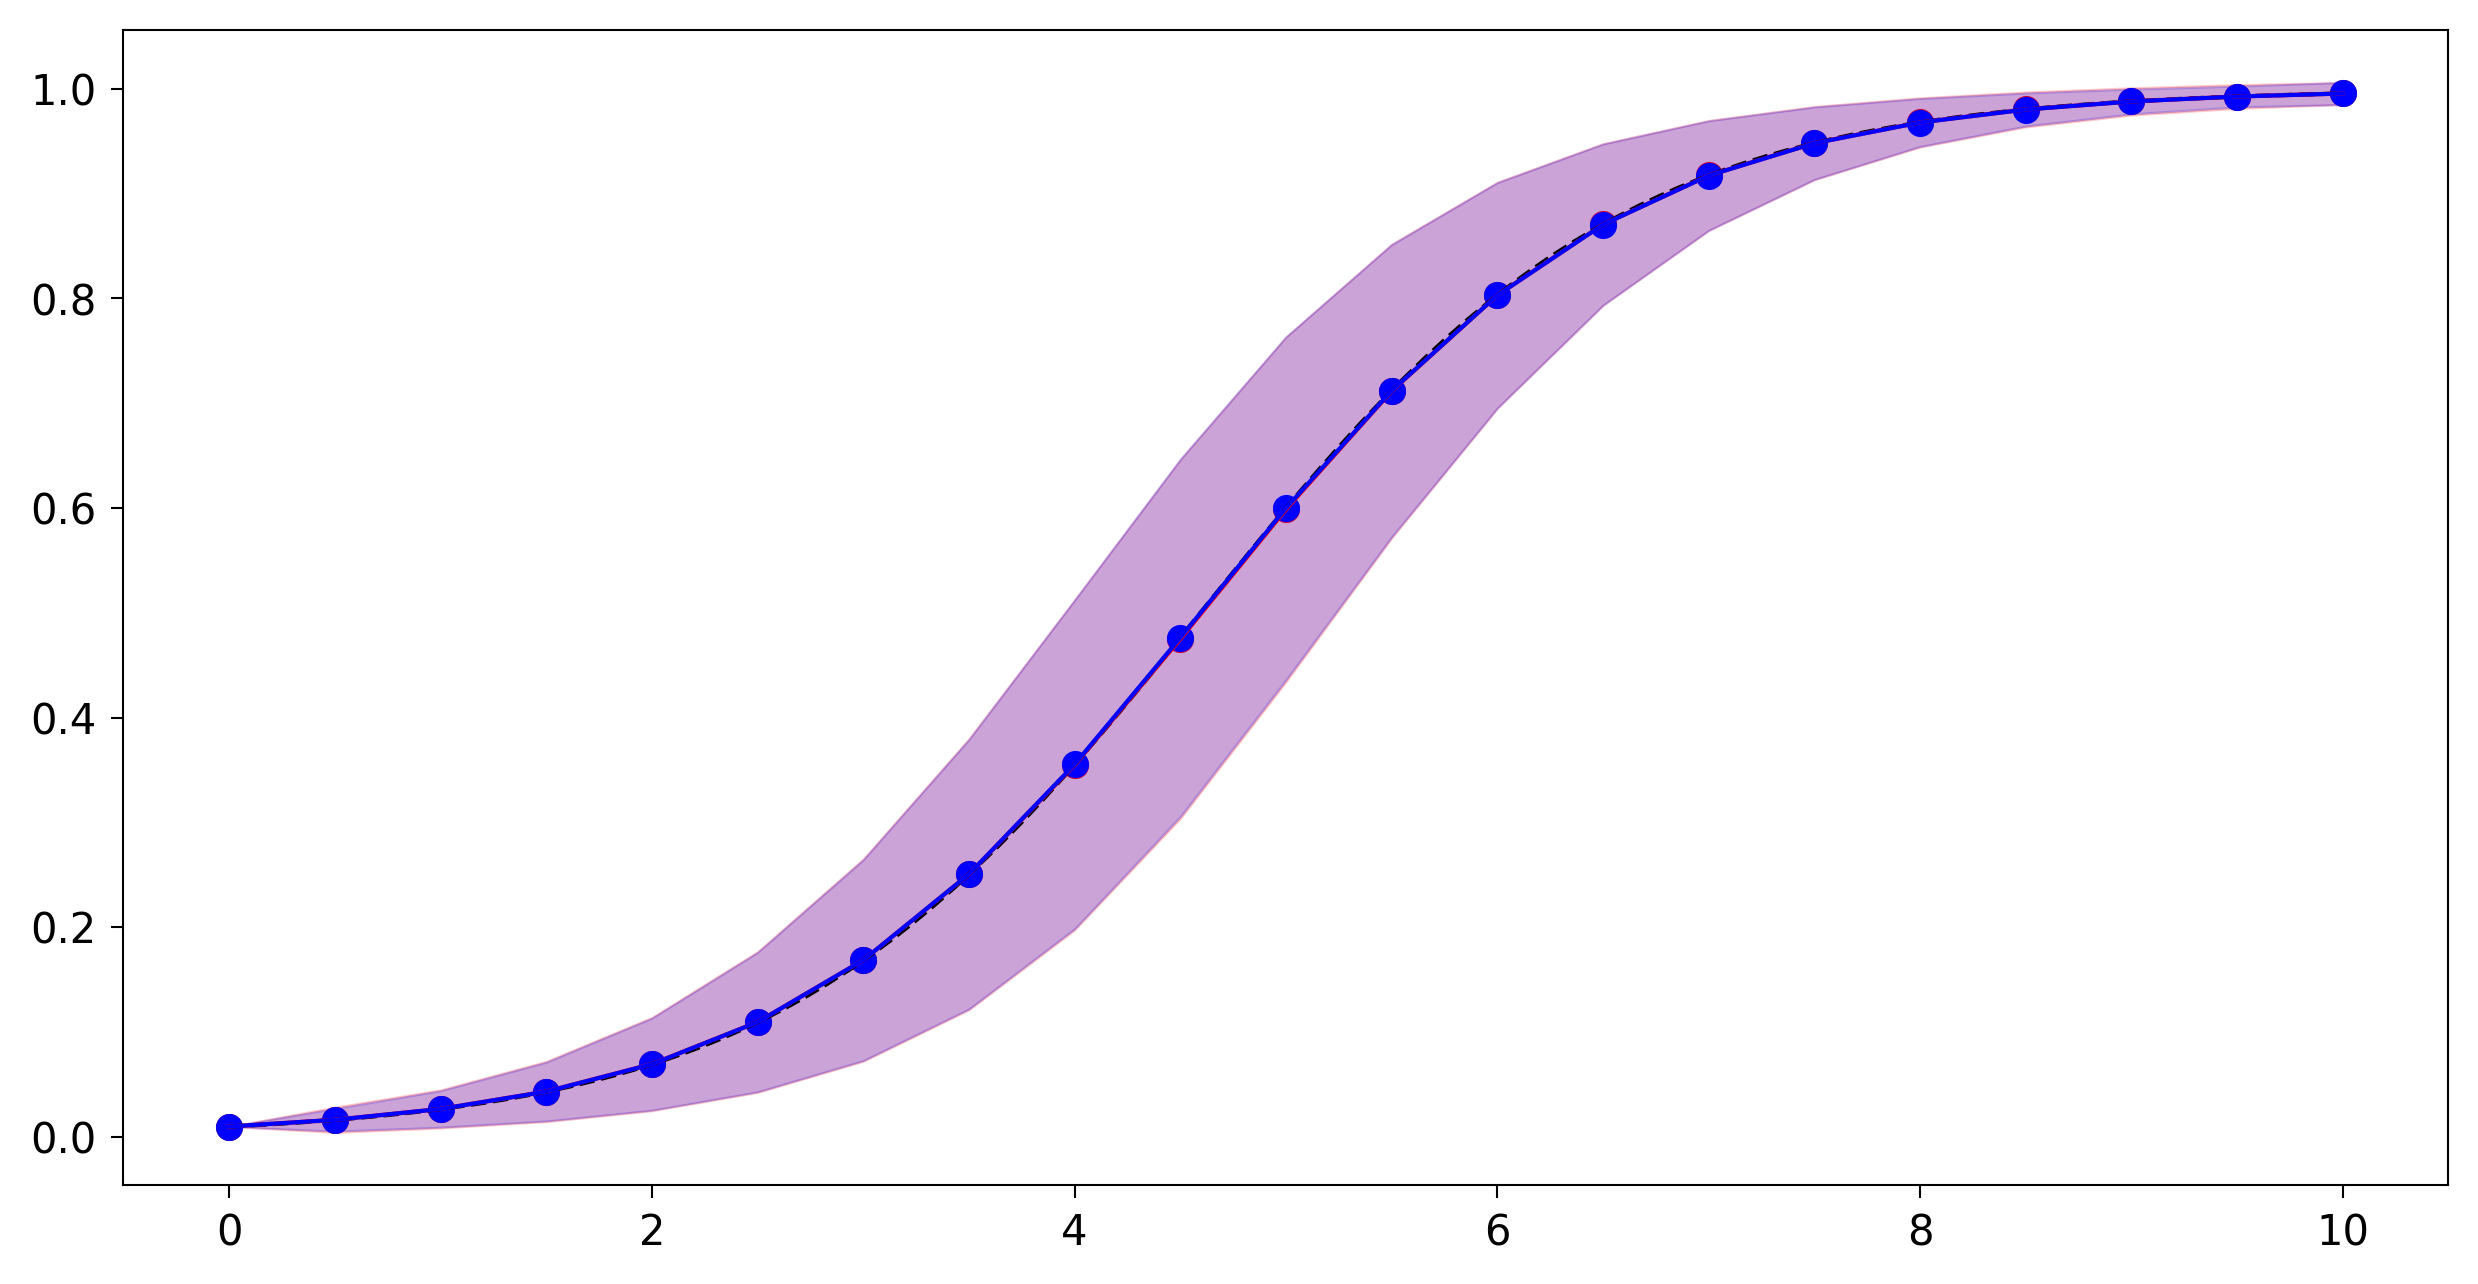

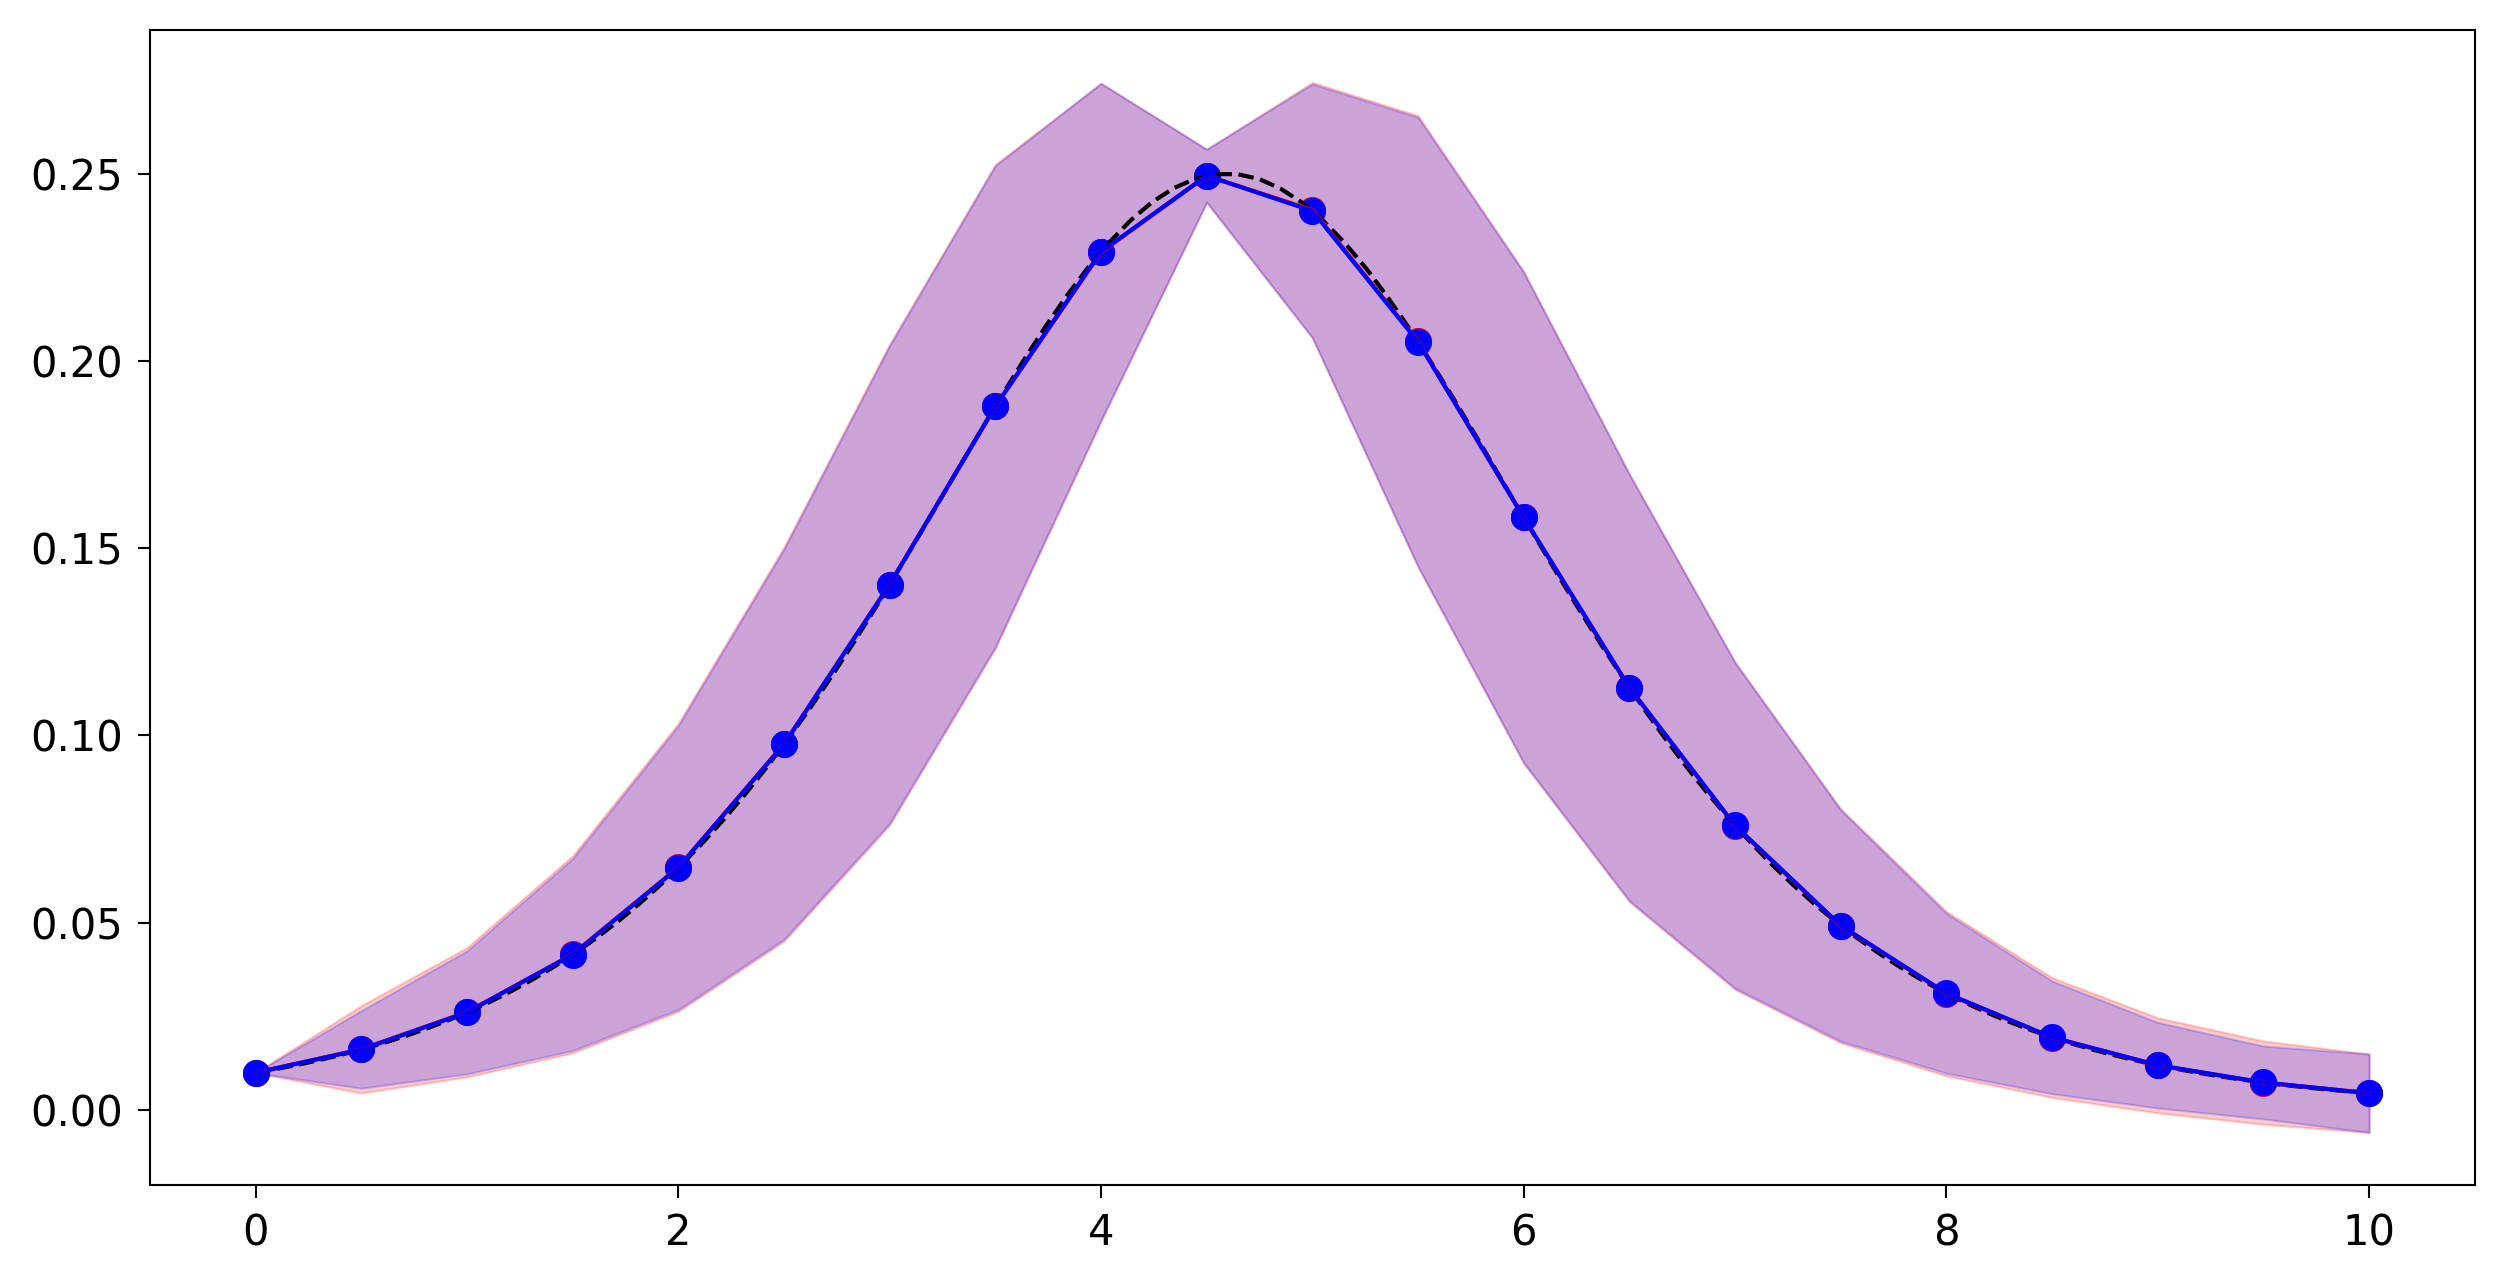

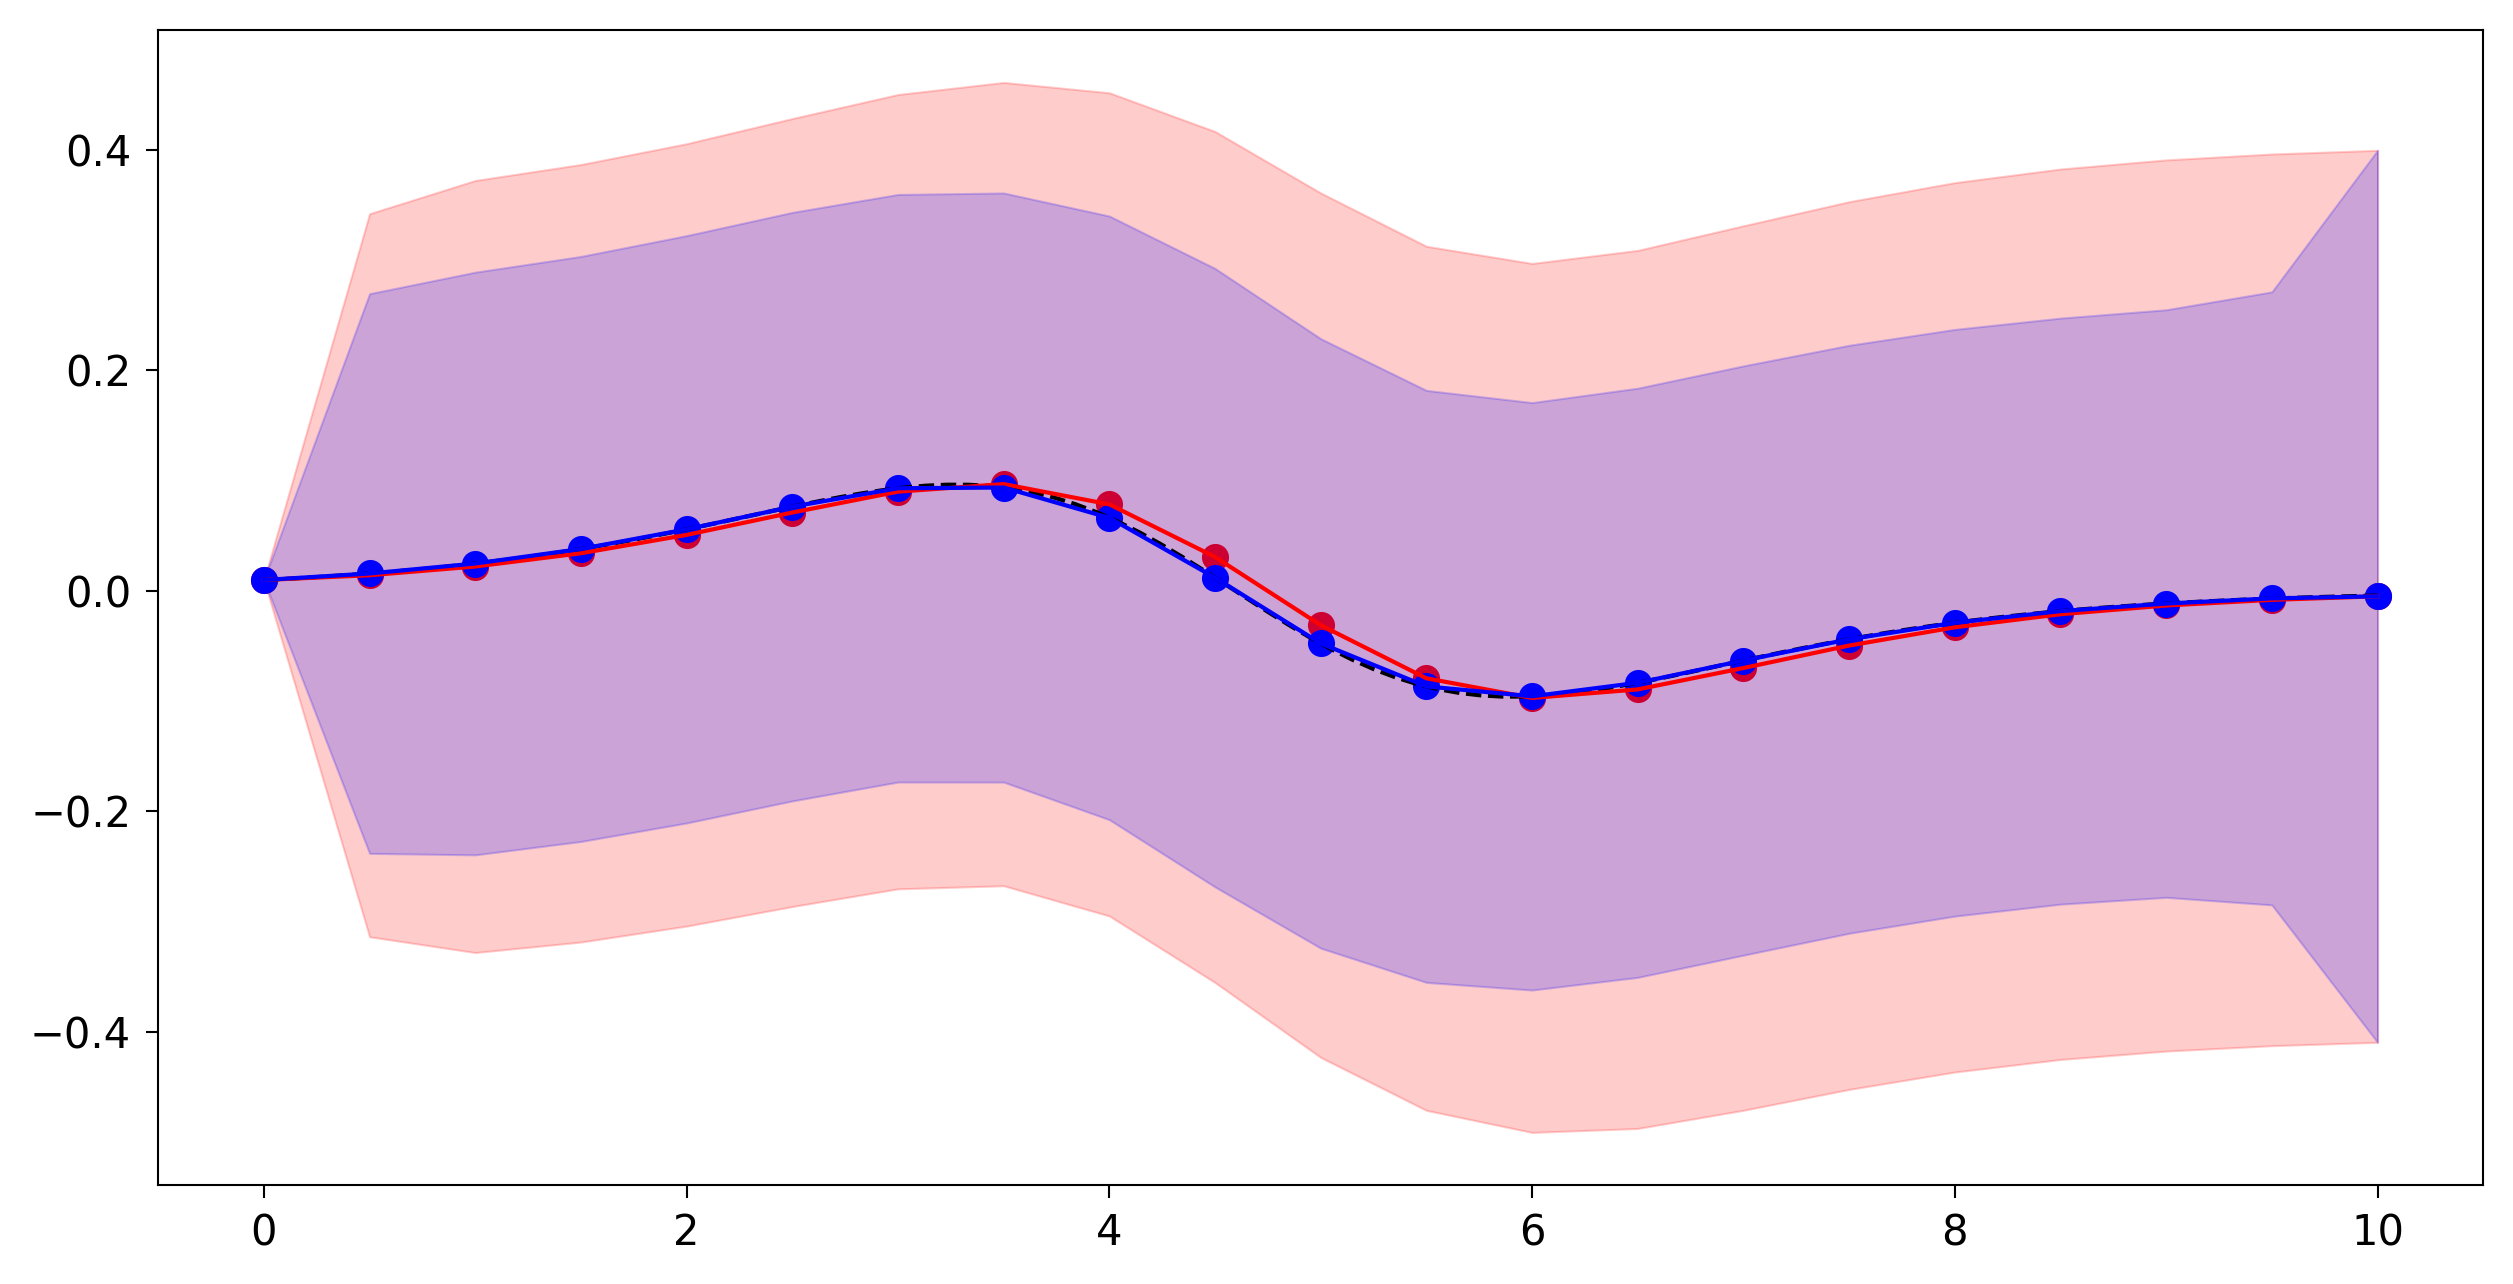

In [12]:
for k in range(3):
    plot_graph2(ts, m_sequence[:,k], P_sequence[:,k,k],m_smoothed[:,k], P_smoothed[:,k,k], t, exact_sols[k])

In [13]:
def plot_ax(ts, m, P, t, x_exact, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    ax.plot(ts, m, color='red', marker='o', label="filtered estimate")
    #ax.scatter(ts, m, color='red', label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    margin = np.sqrt(P_f_safe)
    ax.fill_between(ts, m - margin, m + margin, alpha=0.2, color='red', label=r'$\pm 1\sigma$')
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [14]:
def plot_ax_with_pred(ts, m, P, t, x_exact, m_future, P_future, k, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    ax.plot(ts[:k], m[:k], color='red', marker='.', label="filtered estimate",zorder=8)
    ax.plot(ts[k-1:], m_future, color='black', marker=',', label="future prediction", alpha=0.6)
    #ax.scatter(ts, m, color='red', label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    margin = np.sqrt(P_f_safe)
    margin_future = np.sqrt(P_future)
    ax.fill_between(ts[:k], m[:k] - margin[:k], m[:k] + margin[:k], alpha=0.2, color='red') # label=r'$\pm 1\sigma$'
    ax.fill_between(ts[k-1:], m_future - margin_future, m_future + margin_future, alpha=0.2, color='black')#  label=r'$\pm 1\sigma$'
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [15]:
def plot_ax_with_smooth(ts, m, P, t, x_exact, m_smoothed, P_smoothed, k, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    ax.plot(ts[:k], m[:k], color='red', marker='o', label="filtered estimate",zorder=8)
    ax.plot(ts[k-1:], m_smoothed[k-1:], color='blue', marker='o', label="smoothed estimate", alpha=0.6)
    #ax.scatter(ts, m, color='red', label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    margin = np.sqrt(P_f_safe)
    margin_smoothed = np.sqrt(P_smoothed)
    ax.fill_between(ts[:k], m[:k] - margin[:k], m[:k] + margin[:k], alpha=0.2, color='red') # label=r'$\pm 1\sigma$'
    ax.fill_between(ts[k-1:], m_smoothed[k-1:] - margin_smoothed[k-1:], m_smoothed[k-1:] + margin_smoothed[k-1:], alpha=0.2, color='blue')#  label=r'$\pm 1\sigma$'
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [16]:
zs = m_sequence[:,1] - m_sequence[:,0]*(1 - m_sequence[:,0])
# Uncertainty via linearization
zf_var = []
for k in range(m_sequence.shape[0]):
    Jk = jacobian_g(m_sequence[k, :])
    zf_var.append(Jk @ P_sequence[k, :] @ Jk.T)
zf_var = np.maximum(np.array(zf_var).reshape(-1), 0)

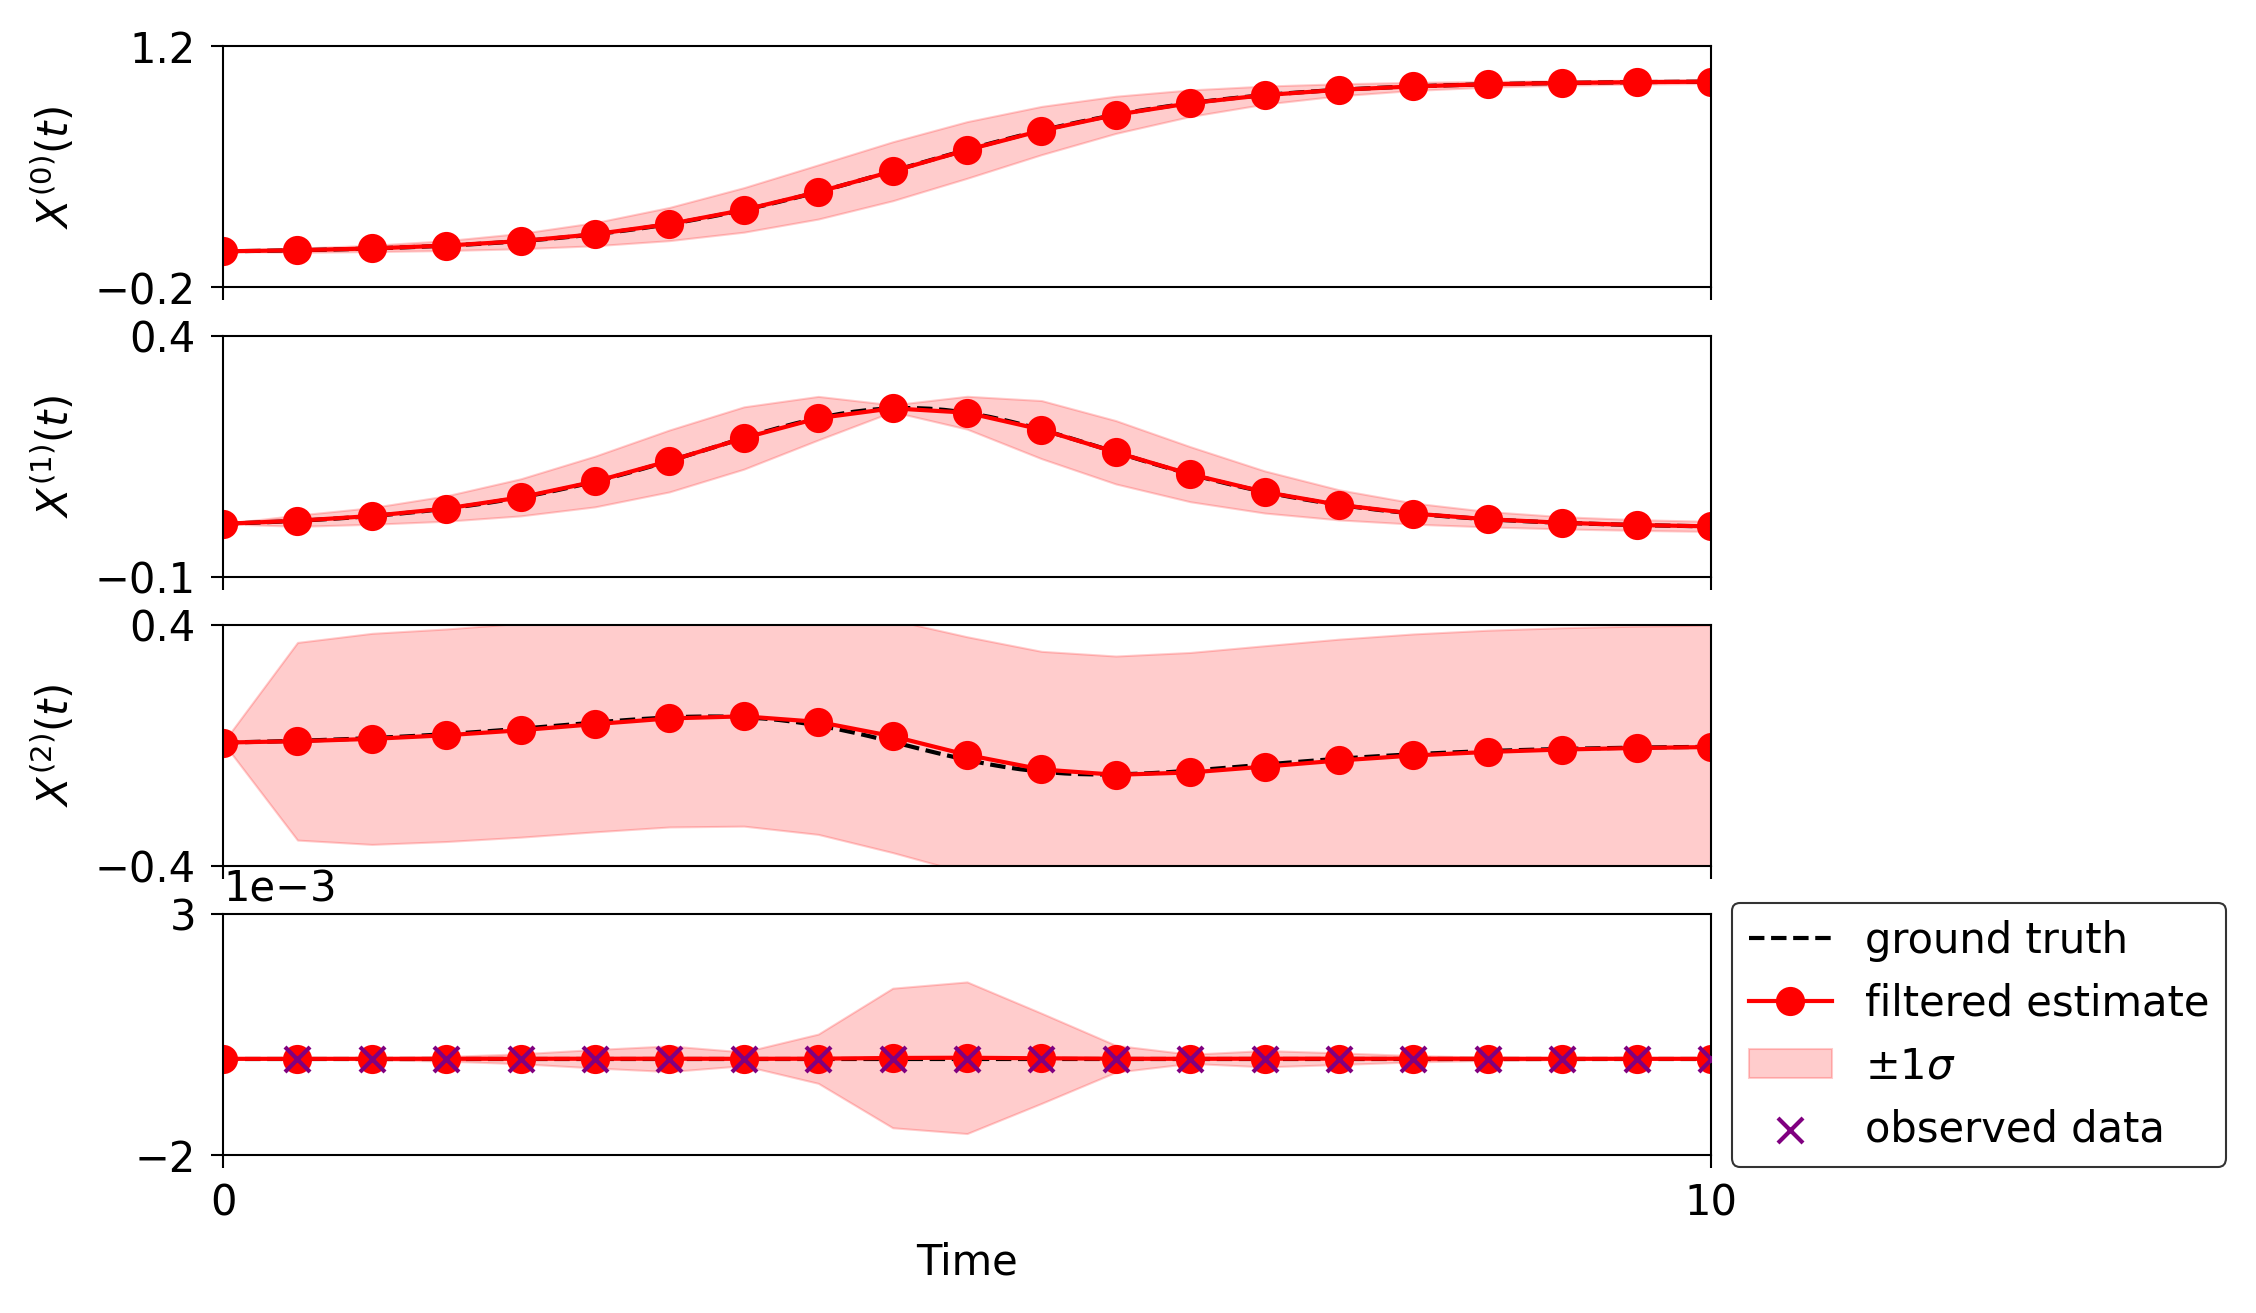

In [17]:
fig, axs = plt.subplots(4, 1, sharex=True)
plot_ax(ts, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
plot_ax(ts, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
plot_ax(ts, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])

for i in range(3):
    # Styling to match other helper
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_xticks([ts[0], ts[-1]])
    axs[i].set_xticklabels([])
    axs[i].set_xlabel('')
    axs[i].grid(False)

plot_ax(ts, zs, zf_var, t, np.zeros_like, x_lim=[0,10], y_lim=[-0.002, 0.003], ax=axs[-1])
axs[-1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axs[-1].scatter(ts[1:], z_sequence, label="observed data", marker='x', color='purple', zorder=10)
axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[-1].set_xlabel("Time")
axs[-1].set_xticklabels([0,10])


#fig.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

In [18]:
k = 13

def predict_future(k):
    m_future = [m_sequence[k-1,:]]
    P_future = [P_sequence[k-1,...]]
    for l in range(N-k+1):
        m_nxt, P_nxt = future_prediction(m_future[-1], P_future[-1], A_h, Q_h)
        m_future.append(m_nxt)
        P_future.append(P_nxt)

    m_future = np.array(m_future)
    P_future = np.array(P_future)
    return m_future, P_future

In [19]:
def create_forward_plot(k, savefig=False):
    m_future, P_future = predict_future(k)
    zs_future = m_future[:,1] - m_future[:,0]*(1 - m_future[:,0])
    # Uncertainty via linearization
    zf_var_future = []
    for m in range(m_future.shape[0]):
        Jk = jacobian_g(m_future[m, :])
        zf_var_future.append(Jk @ P_future[m, :] @ Jk.T)
    zf_var_future = np.maximum(np.array(zf_var_future).reshape(-1), 0)

    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_pred(ts, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], m_future[:,0], P_future[:,0,0], k, x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
    plot_ax_with_pred(ts, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], m_future[:,1], P_future[:,1,1], k, x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
    plot_ax_with_pred(ts, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], m_future[:,2], P_future[:,2,2], k, x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])


    for i in range(3):
        # Styling to match other helper
        axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(False)

    plot_ax_with_pred(ts, zs, zf_var, t, np.zeros_like, zs_future, zf_var_future, k, x_lim=[0,10], y_lim=[-0.1, 0.1], ax=axs[-1])
    axs[-1].scatter(ts[1:k], z_sequence[:k-1], label="observed data", marker='x', color='purple', zorder=10)
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])
    axs[-1].set_ylabel('$g(X(t))$')

    # Build a figure-level legend from all axes
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.9), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_filter_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [20]:
for i in range(1,N+2):
    create_forward_plot(i, savefig=True)

In [21]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

m_smoothed, P_smoothed = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)

zs_smoothed = m_smoothed[:,1] - m_smoothed[:,0]*(1 - m_smoothed[:,0])
# Uncertainty via linearization
zf_var_smoothed = []
for k in range(m_smoothed.shape[0]):
    Jk = jacobian_g(m_smoothed[k, :])
    zf_var_smoothed.append(Jk @ P_smoothed[k, :] @ Jk.T)
zf_var_smoothed = np.maximum(np.array(zf_var_smoothed).reshape(-1), 0)

In [22]:
def create_backward_plot(k, savefig=False):

    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_smooth(ts, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], m_smoothed[:,0], P_smoothed[:,0,0], k, x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
    plot_ax_with_smooth(ts, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], m_smoothed[:,1], P_smoothed[:,1,1], k, x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
    plot_ax_with_smooth(ts, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], m_smoothed[:,2], P_smoothed[:,2,2], k, x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])

    for i in range(3):
        # Styling to match other helper
        axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(False)

    plot_ax_with_smooth(ts, zs, zf_var, t, np.zeros_like, zs_smoothed, zf_var_smoothed, k, x_lim=[0,10], y_lim=[-0.1, 0.1], ax=axs[-1])
    axs[-1].scatter(ts[1:], z_sequence, label="observed data", marker='x', color='purple', zorder=10)
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])
    axs[-1].set_ylabel('$g(X(t))$')

    # Build a figure-level legend from all axes
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.9), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_smoother_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

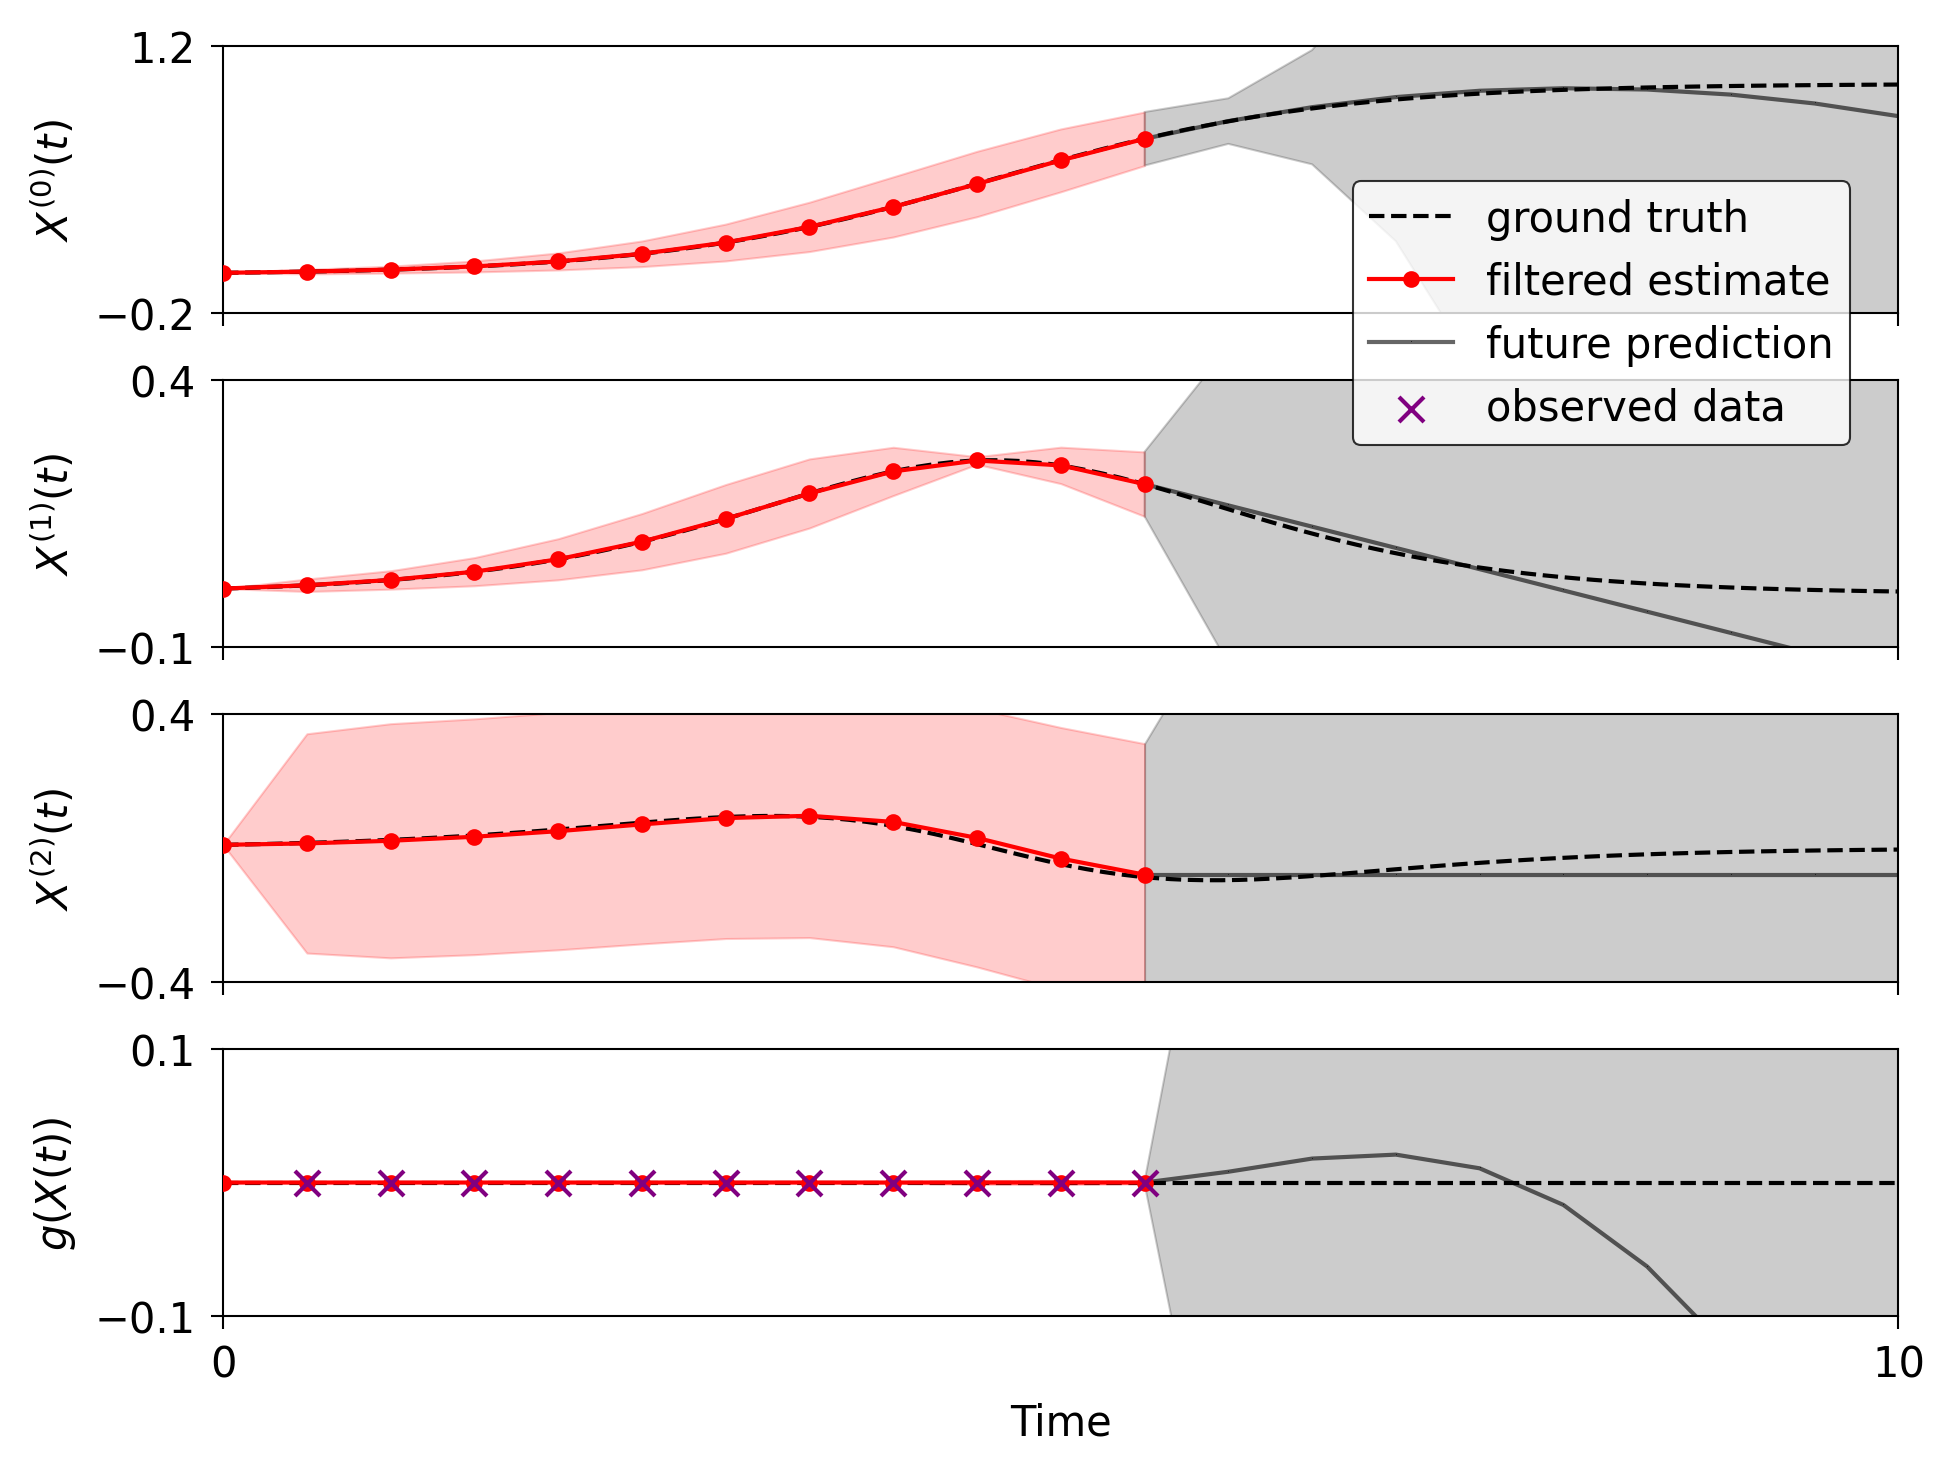

In [23]:
create_forward_plot(12)

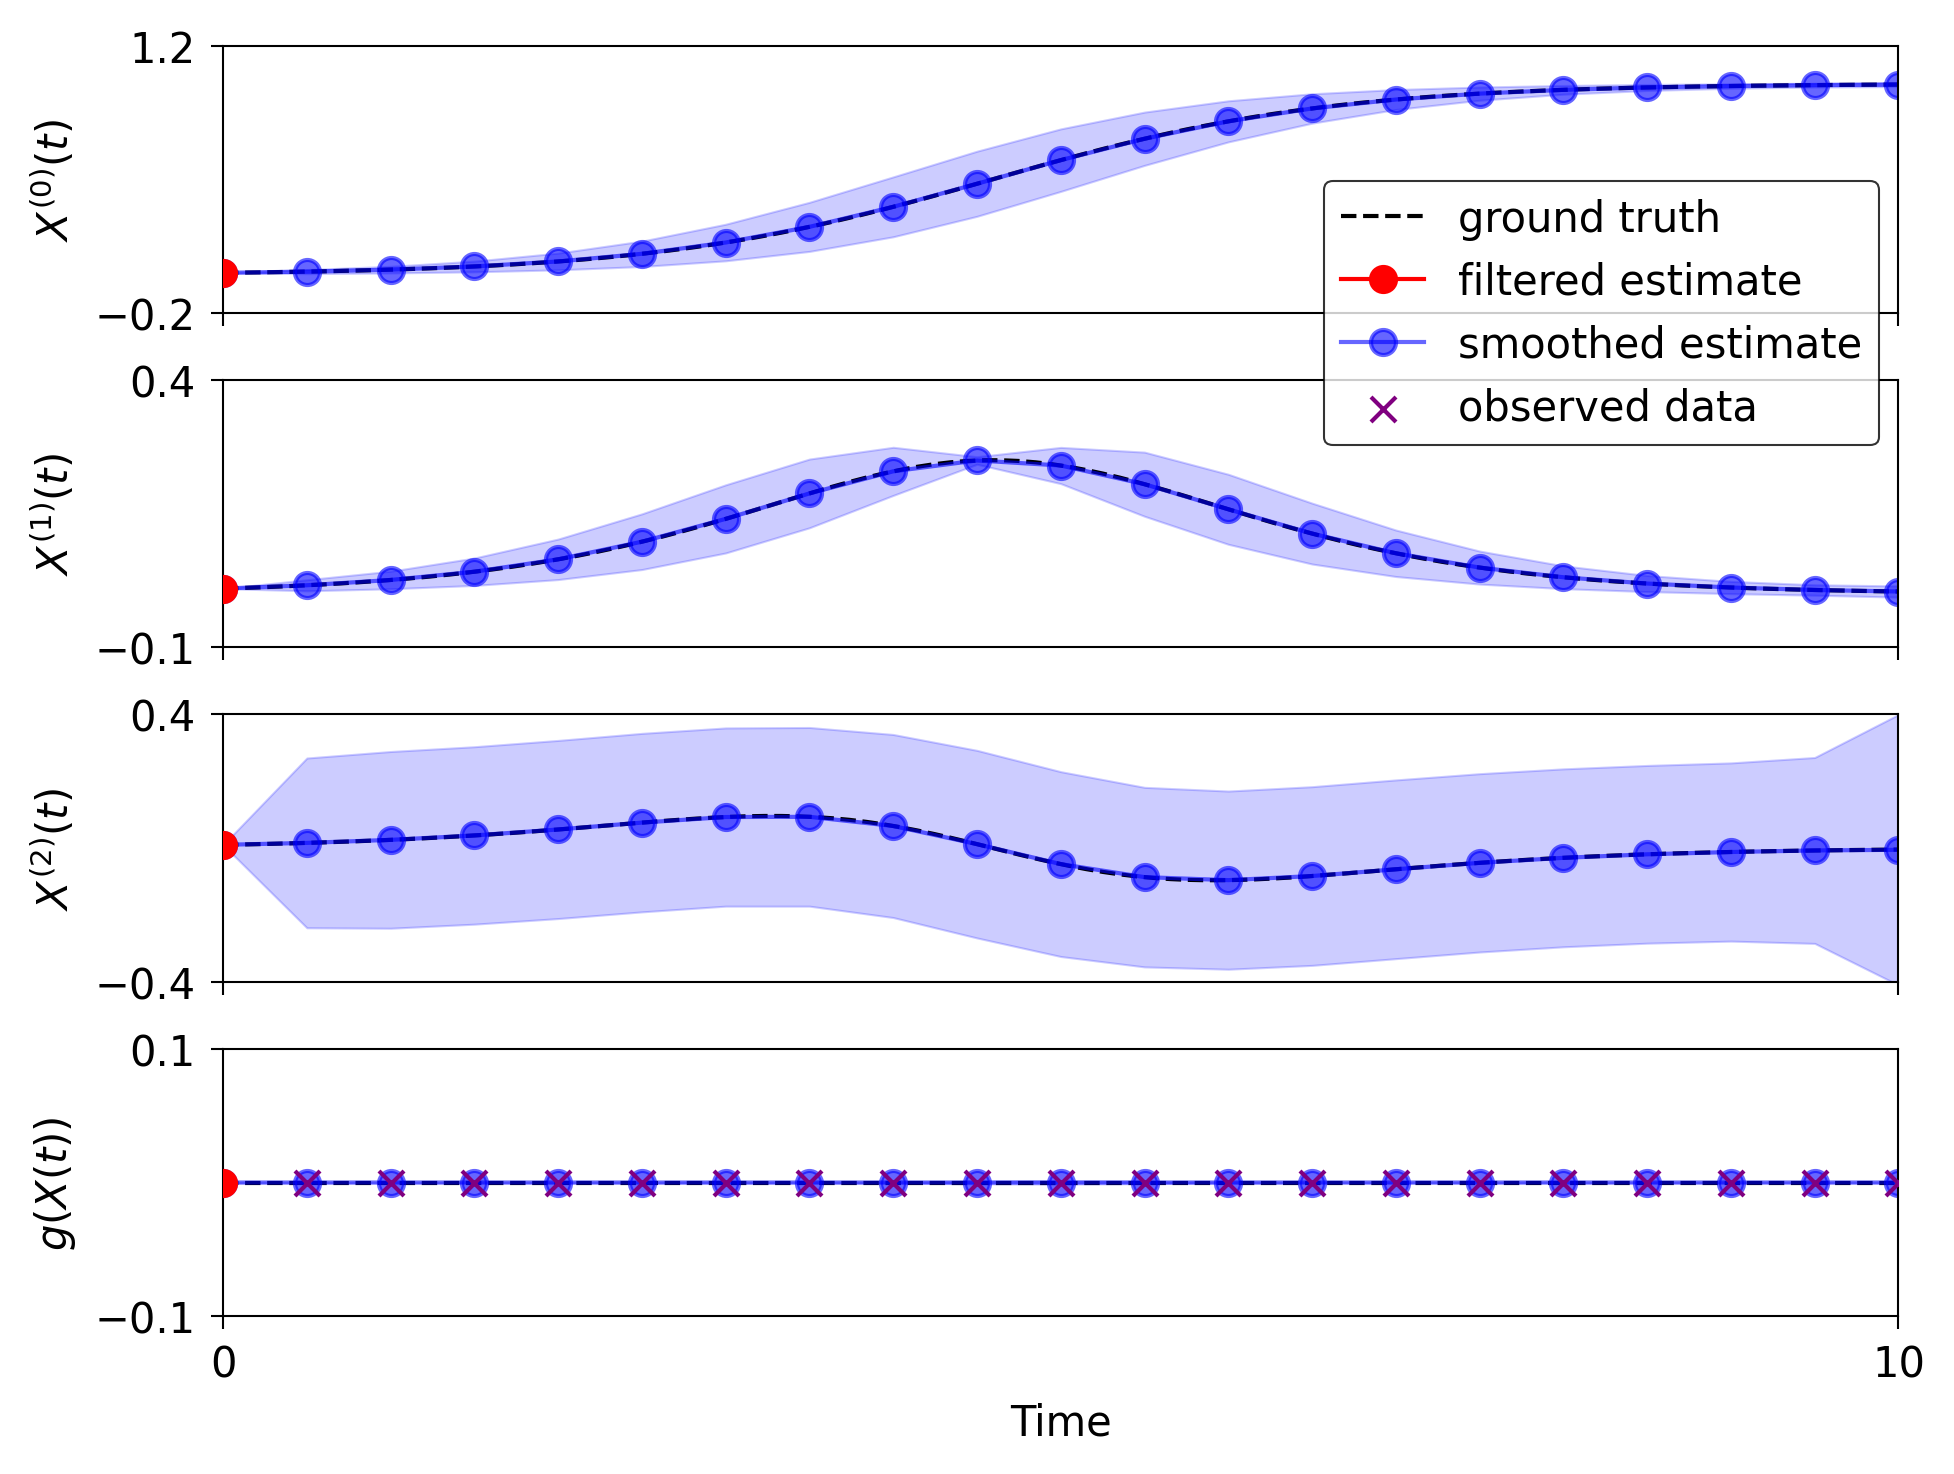

In [24]:
create_backward_plot(1)

In [25]:
for i in range(1,N+2):
    create_backward_plot(i, savefig=True)

In [26]:
def create_forward_plot_all_in_one(k, savefig=False):
    m_future, P_future = predict_future(k)
    zs_future = m_future[:,1] - m_future[:,0]*(1 - m_future[:,0])
    # Uncertainty via linearization
    zf_var_future = []
    for m in range(m_future.shape[0]):
        Jk = jacobian_g(m_future[m, :])
        zf_var_future.append(Jk @ P_future[m, :] @ Jk.T)
    zf_var_future = np.maximum(np.array(zf_var_future).reshape(-1), 0)

    # Overlay X^(0), X^(1), X^(2) on a single axis; keep g(X) below
    fig, axs = plt.subplots(2, 1, sharex=True, layout='constrained')

    # Combined top axis
    plot_ax_with_pred(
        ts, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0],
        m_future[:,0], P_future[:,0,0], k,
        x_lim=[0,10], y_lim=[-0.4, 1.2], ax=axs[0]
    )
    plot_ax_with_pred(
        ts, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1],
        m_future[:,1], P_future[:,1,1], k,
        x_lim=[0,10], y_lim=[-0.4, 1.2], ax=axs[0]
    )
    plot_ax_with_pred(
        ts, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2],
        m_future[:,2], P_future[:,2,2], k,
        x_lim=[0,10], y_lim=[-0.4, 1.2], ax=axs[0]
    )

    axs[0].set_ylabel('$X(t)$')
    axs[0].set_xticks([ts[0], ts[-1]])
    axs[0].set_xticklabels([])
    axs[0].set_xlabel('')
    axs[0].grid(False)

    # Bottom axis for observations
    plot_ax_with_pred(
        ts, zs, zf_var, t, np.zeros_like,
        zs_future, zf_var_future, k,
        x_lim=[0,10], y_lim=[-0.1, 0.1], ax=axs[-1]
    )
    axs[-1].scatter(ts[1:k], z_sequence[:k-1], label="observed data", marker='x', color='purple', zorder=10)
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])
    axs[-1].set_ylabel('$g(X(t))$')

    # Figure-level legend (deduplicated)
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.9), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_filter_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()


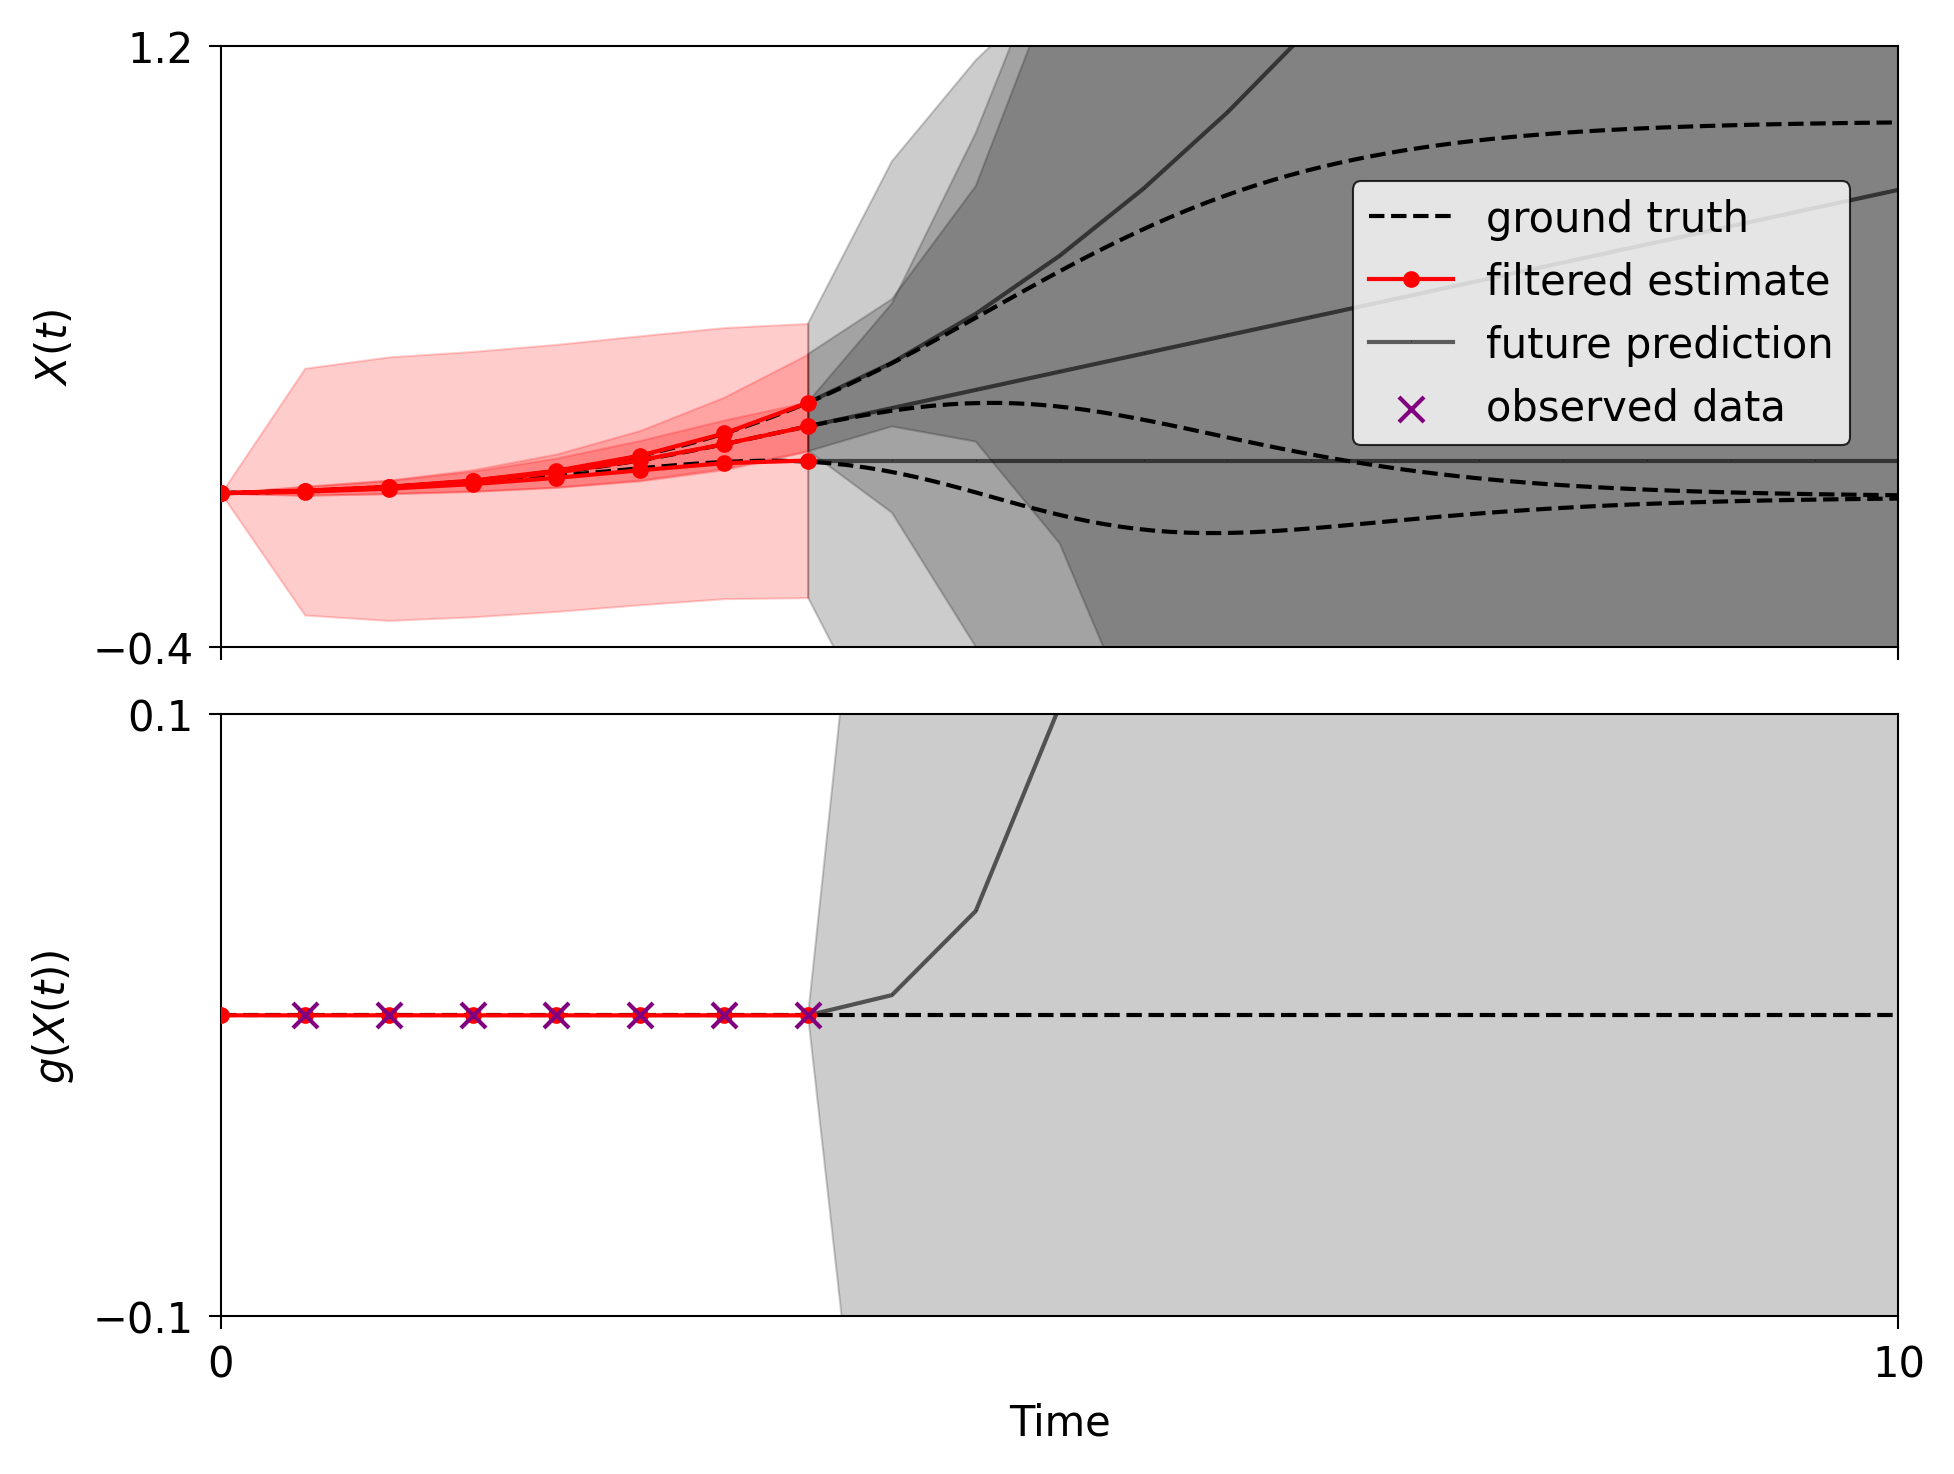

In [27]:
create_forward_plot_all_in_one(8)

In [28]:
def create_forward_plot_with_smooth(k, savefig=False):
    m_future, P_future = predict_future(k)
    zs_future = m_future[:,1] - m_future[:,0]*(1 - m_future[:,0])
    # Uncertainty via linearization
    zf_var_future = []
    for m in range(m_future.shape[0]):
        Jk = jacobian_g(m_future[m, :])
        zf_var_future.append(Jk @ P_future[m, :] @ Jk.T)
    zf_var_future = np.maximum(np.array(zf_var_future).reshape(-1), 0)

    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_pred(ts, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], m_future[:,0], P_future[:,0,0], k, x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
    plot_ax_with_pred(ts, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], m_future[:,1], P_future[:,1,1], k, x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
    plot_ax_with_pred(ts, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], m_future[:,2], P_future[:,2,2], k, x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])

    #print(m_sequence.shape)
    #print(m_sequence[k,...])
    #m_smoothed, P_smoothed = compute_kalman_backward(m_sequence[:k,:], P_sequence[:k,...], m_predictions[:k,:], P_predictions[:k,...], A_h, k-1)

    l = k-1
    m_smoothed = [m_sequence[l,...]]
    P_smoothed = [P_sequence[l,...]]
    for i in range(1,l+1):
        m_t_s, P_t_s = kf_smoother_step(m_sequence[l-i], P_sequence[l-i,...], A_h, m_predictions[l-i], P_predictions[l-i,...],  m_smoothed[-1], P_smoothed[-1])
        m_smoothed.append(m_t_s)
        P_smoothed.append(P_t_s)
    m_smoothed = np.array(m_smoothed)[::-1]
    P_smoothed = np.array(P_smoothed)[::-1]

    margin_smoothed = np.sqrt(np.abs(P_smoothed))

    axs[0].plot(ts[:k], m_smoothed[:,0], marker='*')
    axs[1].plot(ts[:k], m_smoothed[:,1], marker='*')
    axs[2].plot(ts[:k], m_smoothed[:,2], marker='*')

    
    axs[0].fill_between(ts[:k], m_smoothed[:,0] - margin_smoothed[:,0,0], m_smoothed[:,0] + margin_smoothed[:,0,0], alpha=0.2, color='blue')#  label=r'$\pm 1\sigma$'
    axs[1].fill_between(ts[:k], m_smoothed[:,1] - margin_smoothed[:,1,1], m_smoothed[:,1] + margin_smoothed[:,1,1], alpha=0.2, color='blue')#  label=r'$\pm 1\sigma$'
    axs[2].fill_between(ts[:k], m_smoothed[:,2] - margin_smoothed[:,2,2], m_smoothed[:,2] + margin_smoothed[:,2,2], alpha=0.2, color='blue')#  label=r'$\pm 1\sigma$'

    for i in range(3):
        # Styling to match other helper
        axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(False)

    plot_ax_with_pred(ts, zs, zf_var, t, np.zeros_like, zs_future, zf_var_future, k, x_lim=[0,10], y_lim=[-0.1, 0.1], ax=axs[-1])
    axs[-1].scatter(ts[1:k], z_sequence[:k-1], label="observed data", marker='x', color='purple', zorder=10)
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])
    axs[-1].set_ylabel('$g(X(t))$')

    # Build a figure-level legend from all axes
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.9), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_filter_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

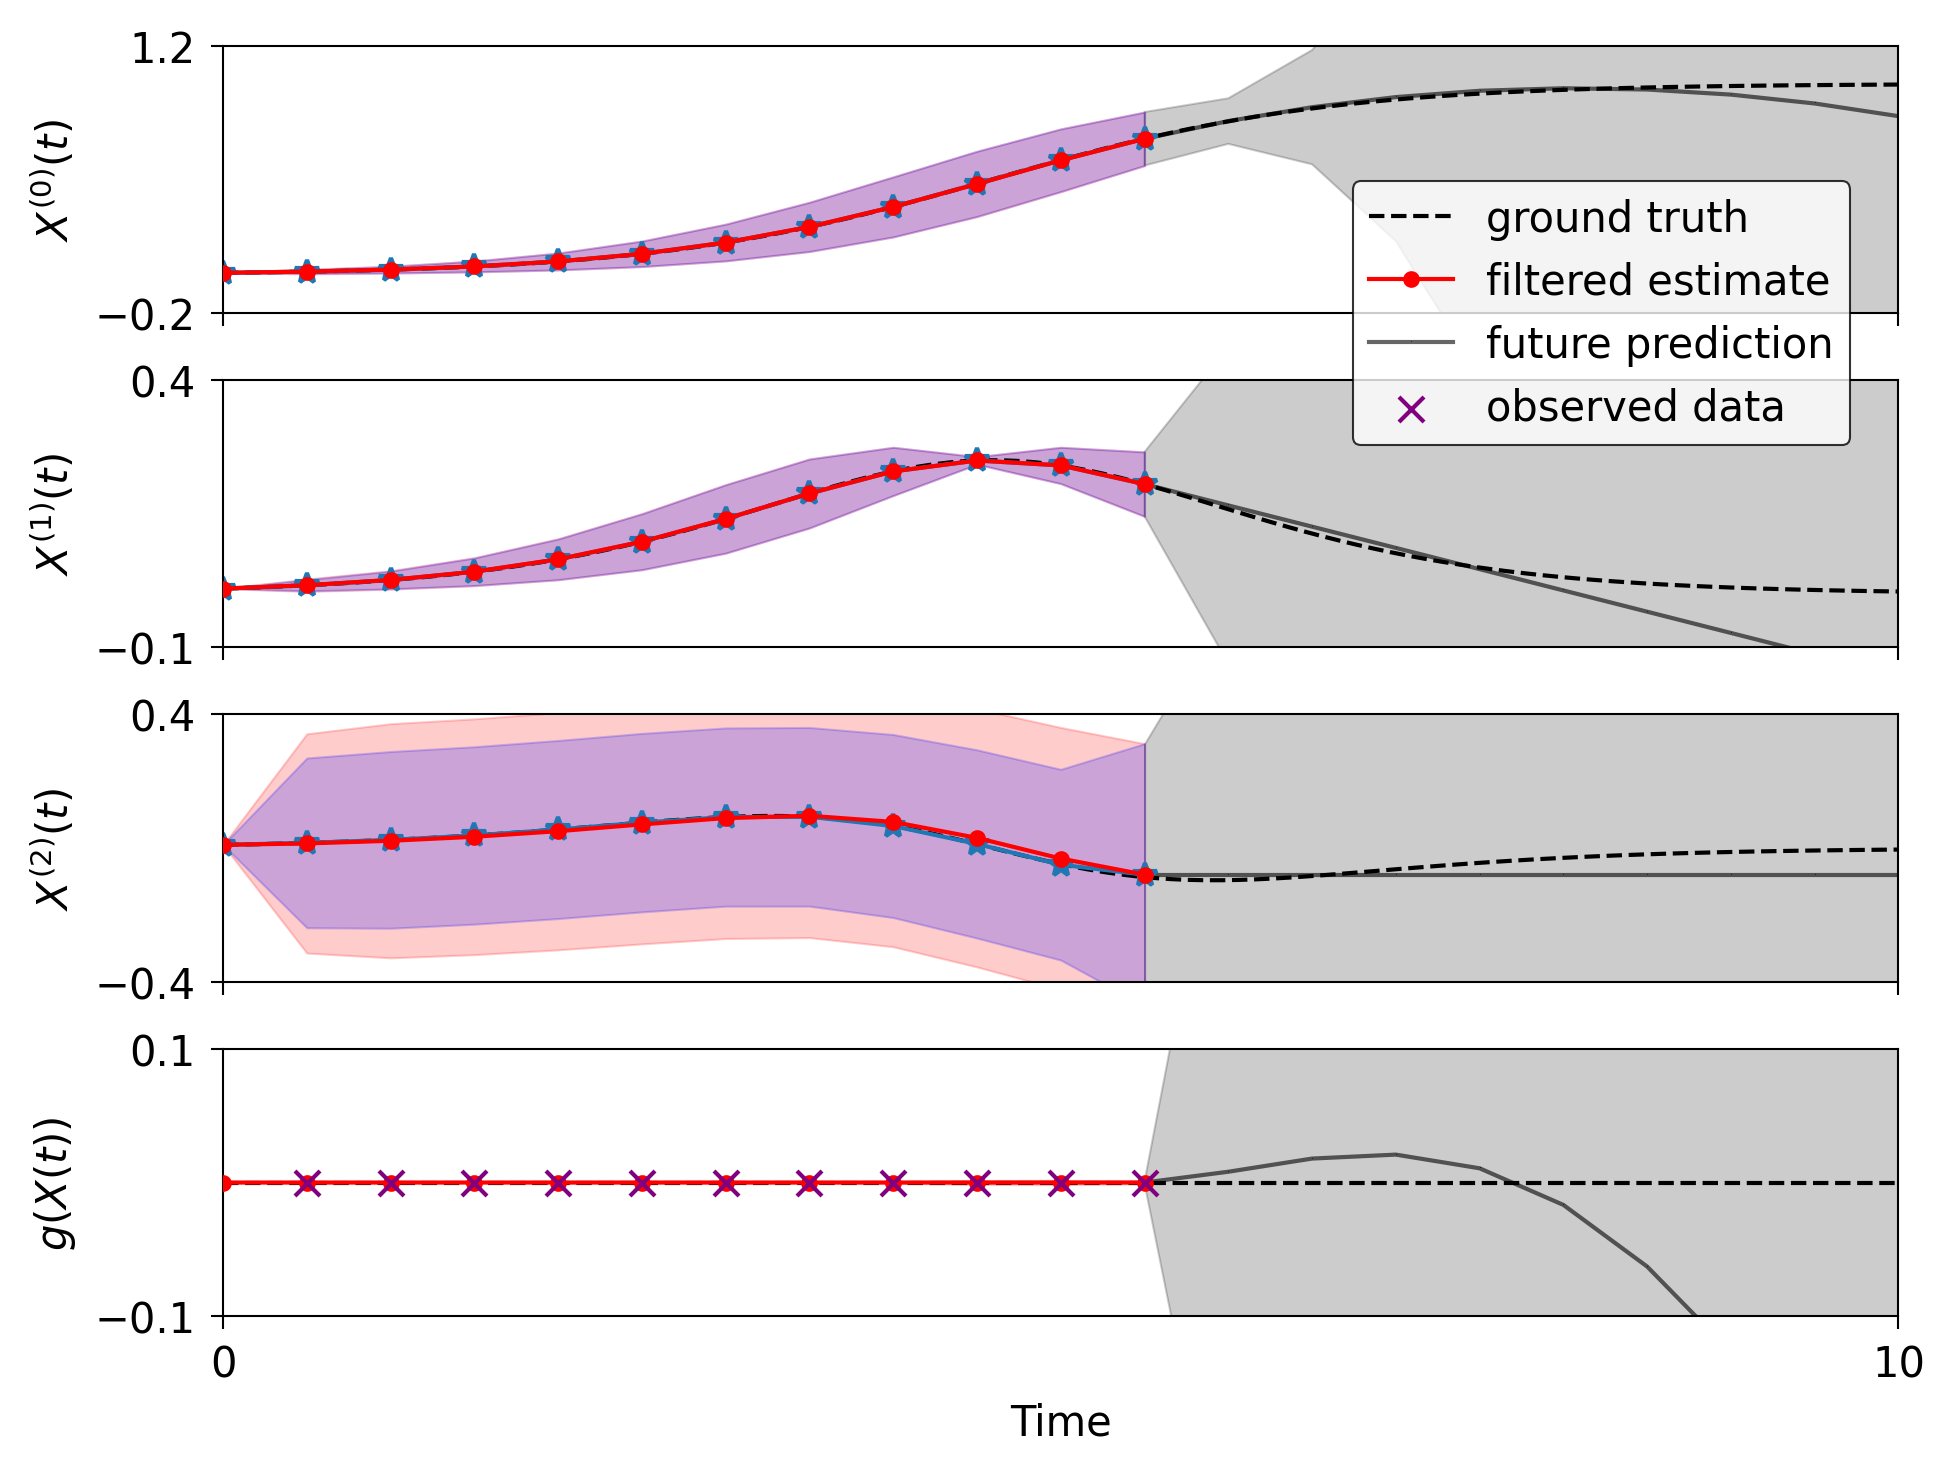

In [29]:
create_forward_plot_with_smooth(12)

In [30]:
def plot_ax_with_smooth2(ts, m, P, t, x_exact, m_smoothed, P_smoothed, k, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    #ax.plot(ts[:k], m[:k], color='red', marker='o', label="filtered estimate",zorder=8)
    ax.plot(ts[k-1:], m_smoothed[k-1:], color='blue', marker='.', label="smoothed estimate", alpha=0.6)
    #ax.scatter(ts, m, color='red', label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    #margin = np.sqrt(P_f_safe)
    margin_smoothed = np.sqrt(P_smoothed)
    #ax.fill_between(ts[:k], m[:k] - margin[:k], m[:k] + margin[:k], alpha=0.2, color='red') # label=r'$\pm 1\sigma$'
    ax.fill_between(ts[k-1:], m_smoothed[k-1:] - margin_smoothed[k-1:], m_smoothed[k-1:] + margin_smoothed[k-1:], alpha=0.2, color='blue')#  label=r'$\pm 1\sigma$'
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [35]:
def create_smoothed_plot(k=N, savefig=False):

    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_smooth2(ts, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], m_smoothed[:,0], P_smoothed[:,0,0], k, x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
    plot_ax_with_smooth2(ts, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], m_smoothed[:,1], P_smoothed[:,1,1], k, x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
    plot_ax_with_smooth2(ts, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], m_smoothed[:,2], P_smoothed[:,2,2], k, x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])

    for i in range(3):
        # Styling to match other helper
        axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(False)

    plot_ax_with_smooth2(ts, zs, zf_var, t, np.zeros_like, zs_smoothed, zf_var_smoothed, k, x_lim=[0,10], y_lim=[-0.0011, 0.0011], ax=axs[-1])
    axs[-1].scatter(ts[1:], z_sequence, label="observed data", marker='x', color='purple', zorder=10)
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    axs[-1].set_xticklabels([0,10])
    axs[-1].set_ylabel('$g(X(t))$')

    # Build a figure-level legend from all axes
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.9), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_smoother_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

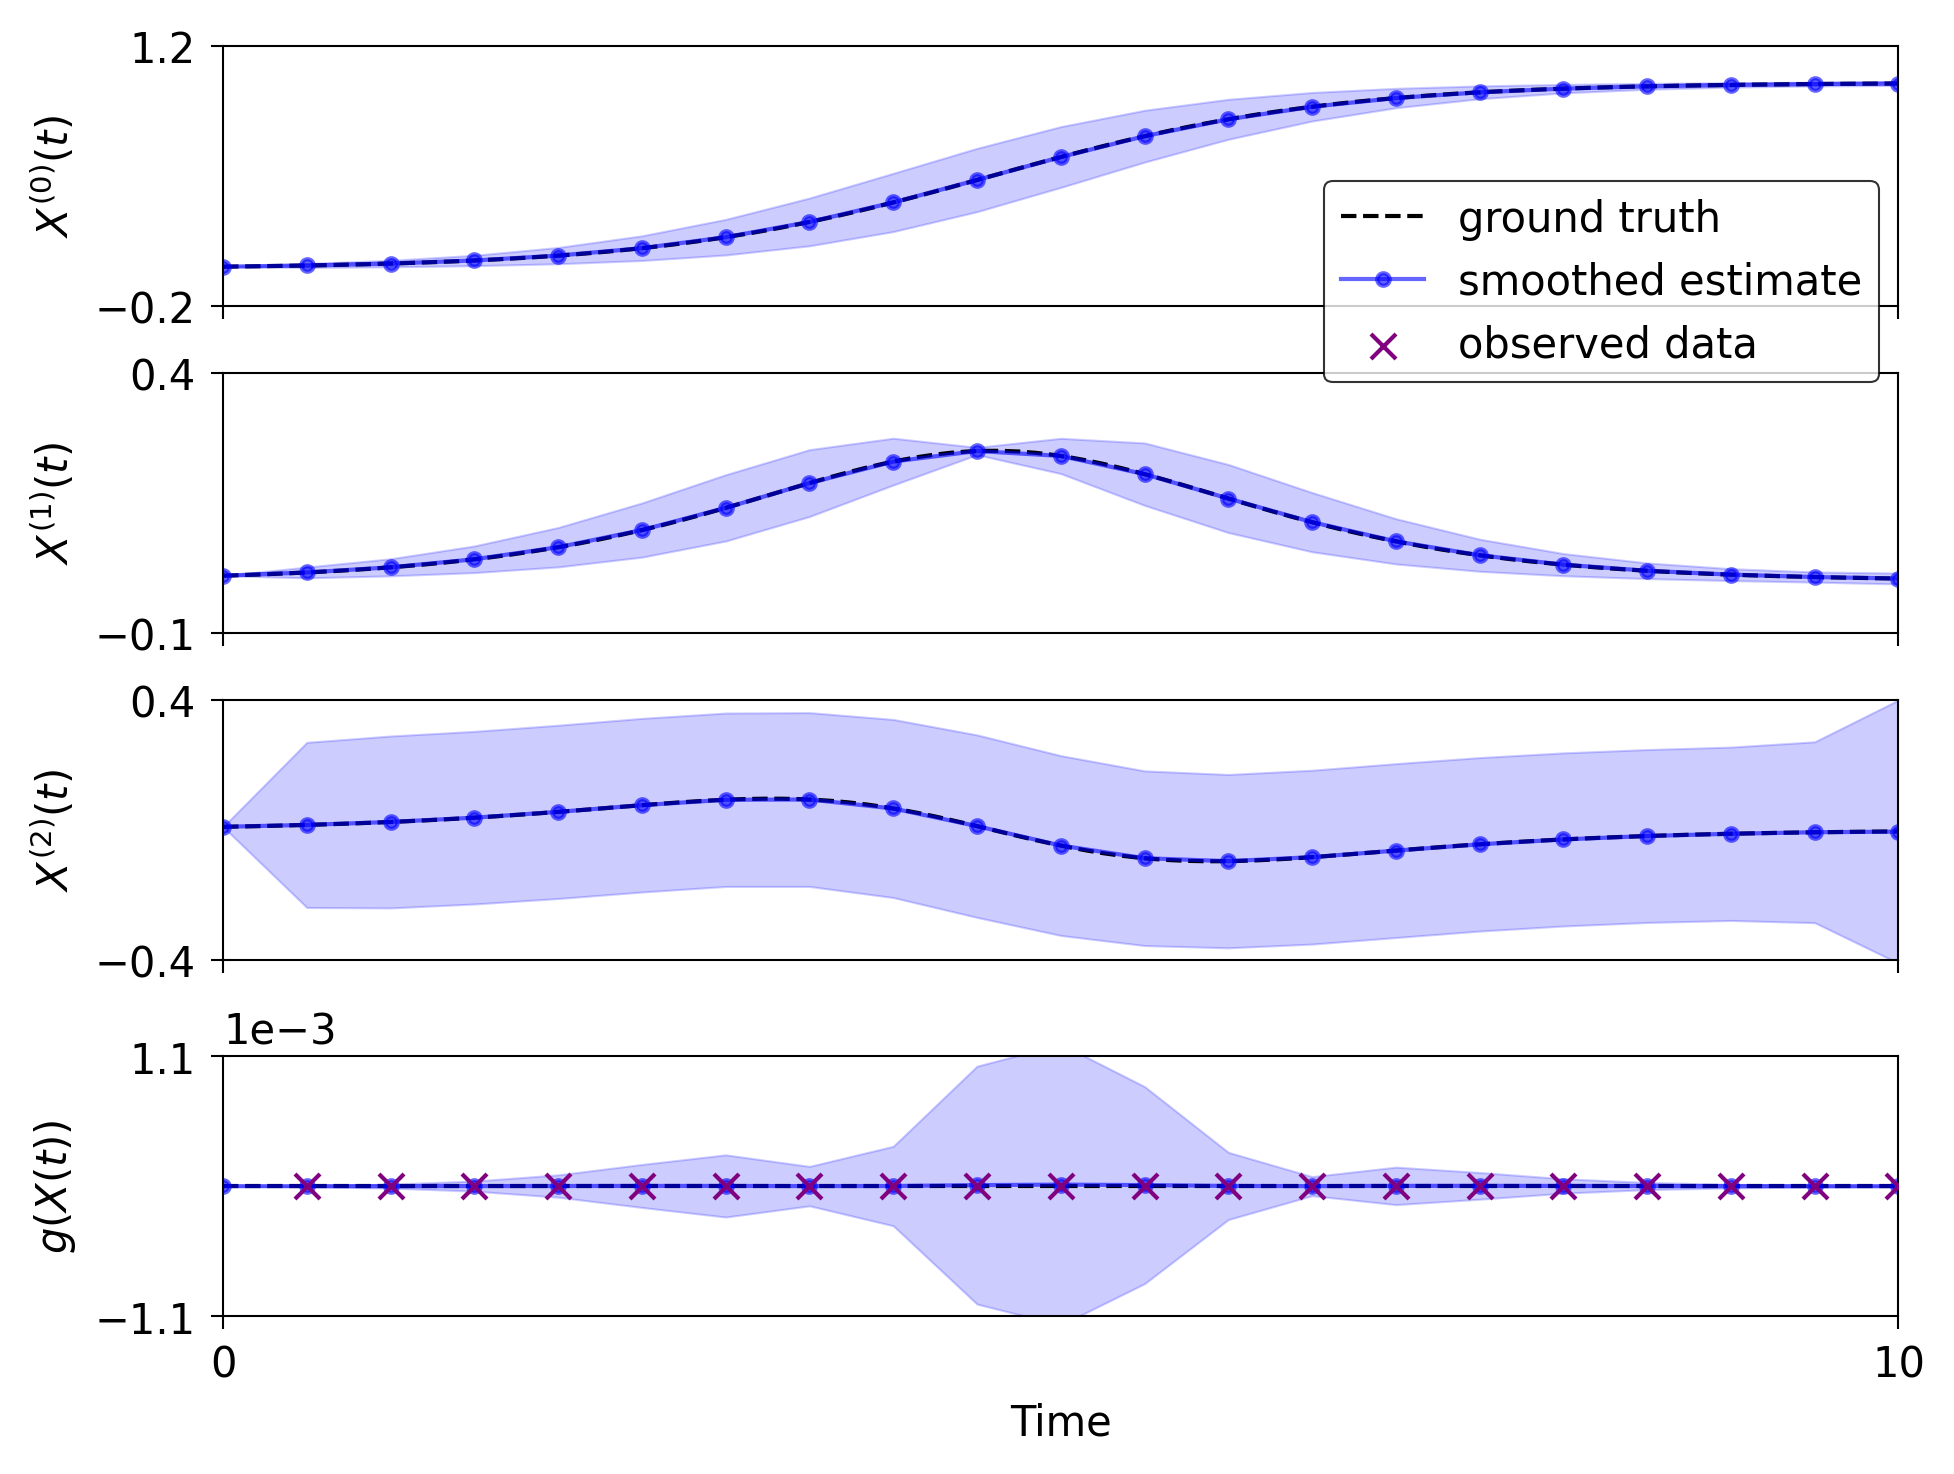

In [36]:
create_smoothed_plot(1)